## Perturbation of sequences
### Dataset: Coronaviridae S Protein sequences of Humans only
### Number of sequences = 2400
### Model: CNN

In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jup

In [3]:
from prediction.models.nlp import transformer, transformer_model, cnn1d, lstm, fnn
from prediction.datasets.protein_sequence_dataset import ProteinSequenceDataset
from src.utils import utils, nn_utils
from src.utils.nlp_utils.padding import Padding
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
input_file_path = "/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/coronaviridae_top_7_hosts_human.csv"
output_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20230917/perturbed_dataset_prediction/cnn-l_4-lr1e-3/processed"
models_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20230908"


uniprotkb_coronaviruses_human_df = pd.read_csv(input_file_path)

label_groupings = {
                    "Pig": [ "Sus scrofa (Pig) [TaxID: 9823]" ],
                    "Human": [ "Homo sapiens (Human) [TaxID: 9606]" ],
                    "Wild turkey": [ "Meleagris gallopavo (Wild turkey) [TaxID: 9103]" ],
                    "Japanese pipistrelle": [ "Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]" ],
                    "Lesser bamboo bat": [ "Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]" ],
                    "Chicken": [ "Gallus gallus (Chicken) [TaxID: 9031]" ],
                    "Bovine": [ "Bos taurus (Bovine) [TaxID: 9913]" ]
                }

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}

idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

test_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 1,
    "max_sequence_length": 1453,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}


label_settings = {
    "label_col": "virus_host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 1453,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 4,
    "n_tokens": 27,
    "n_classes": 7,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024,
    "kernel_size": 3,
    "stride": 1
}

In [5]:
uniprotkb_coronaviruses_human_df

id                                                seq  \
0     P0DTC2  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   
1     P15423  MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...   
2     P36334  MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNG...   
3     Q0ZME7  MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...   
4     Q14EB0  MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...   
...      ...                                                ...   
2395  T1PZ80  MKLFLILLVLPLASCFFTCNSNANLSMLQLGVPDNSSTIVTGLLPT...   
2396  T1PZ81  MFLILLISLPTAFAVIGDLNCPLDTRLKGSFNNRDTGPPSISTDTV...   
2397  T1PZ82  QADSFTCNNIDAAKIYGMCFSSITIDKFAIPNRRKVDLQLGNLGYL...   
2398  T1PZ83  MFLILLISLPTAFAVIGDLNCPLDPRLKGSFNNRDTGPPSISTDTV...   
2399  U3PXJ8  TYNCTDAVLTYSSFGVCADGSIIAVQPRNVSYDSVSAIVTANLSIP...   

                                                  virus  seq_len  \
0     Severe acute respiratory syndrome coronavirus ...     1273   
1                    Human coronavirus 229E (HCoV-229E)     1173   
2                    Human coronavirus OC43 (HCoV-OC43)     1353   
3       Human coronavirus HKU1 (isolate N5) (HCoV-HKU1)     1351   
4       Human coronavirus HKU1 (isolate N2) (HCoV-HKU1)     1351   
...                                                 ...      ...   
2395                 Human coronavirus NL63 (HCoV-NL63)      643   
2396                 Human coronavirus OC43 (HCoV-OC43)      929   
2397                 Human coronavirus OC43 (HCoV-OC43)      297   
2398                 Human coronavirus OC43 (HCoV-OC43)      933   
2399                 Human coronavirus 229E (HCoV-229E)      585   

                              virus_host binary_label  
0     Homo sapiens (Human) [TaxID: 9606]        Human  
1     Homo sapiens (Human) [TaxID: 9606]        Human  
2     Homo sapiens (Human) [TaxID: 9606]        Human  
3     Homo sapiens (Human) [TaxID: 9606]        Human  
4     Homo sapiens (Human) [TaxID: 9606]        Human  
...                                  ...          ...  
2395  Homo sapiens (Human) [TaxID: 9606]        Human  
2396  Homo sapiens (Human) [TaxID: 9606]        Human  
2397  Homo sapiens (Human) [TaxID: 9606]        Human  
2398  Homo sapiens (Human) [TaxID: 9606]        Human  
2399  Homo sapiens (Human) [TaxID: 9606]        Human  

[2400 rows x 6 columns]

<AxesSubplot:xlabel='seq_len', ylabel='Count'>

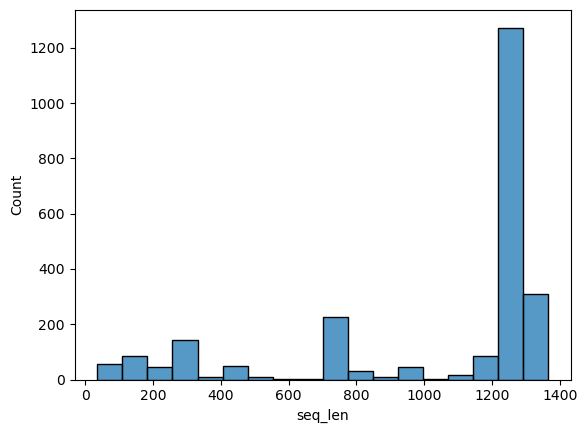

In [6]:
sns.histplot(uniprotkb_coronaviruses_human_df["seq_len"])

In [12]:
def get_token_dataset_loader(df, sequence_settings, label_settings):
    label_col = label_settings["label_col"]
    
    seq_col = sequence_settings["sequence_col"]
    batch_size = sequence_settings["batch_size"]
    max_seq_len = sequence_settings["max_sequence_length"]
    pad_sequence_val = sequence_settings["pad_sequence_val"]
    truncate = sequence_settings["truncate"]
    
    df = df[[seq_col, label_col]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi", silent=True)

    dataset = ProteinSequenceDataset(df, seq_col, max_seq_len, truncate, label_col)
    return index_label_map, DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                      collate_fn=Padding(max_seq_len, pad_sequence_val))


def get_dataset_loader_for_seq(uniprot_id):
    id_df = uniprotkb_coronaviruses_human_df[uniprotkb_coronaviruses_human_df["id"] == uniprot_id]
    print(f"Size {uniprot_id} df = {uniprotkb_coronaviruses_human_df.shape}")
    index_label_map, dataset_loader =  get_token_dataset_loader(id_df, test_sequence_settings, label_settings)
    return id_df, index_label_map, dataset_loader

### Load the model

In [8]:
cnn_model = cnn1d.get_cnn_model(model)
cnn_model.load_state_dict(torch.load(os.path.join(models_dir, "host_multi_lr1e-3-e50", "cnn-l_4-lr1e-3_itr0.pth")))
cnn_model = cnn_model.to(nn_utils.get_device())
cnn_model.eval()
cnn_model.zero_grad()

CNN_1D_Model(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (conv1d): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
  (conv1d_hidden): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  (conv1d_hidden_layers): ModuleList(
    (0-2): 3 x Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  )
  (linear): Linear(in_features=1024, out_features=7, bias=True)
)
Number of parameters =  14181895


In [9]:
def validate(model, dataset_loader, index_label_map):
    with torch.no_grad():
        model.eval()

        results = []

        for _, data in enumerate(dataset_loader):
            # get input and labels; data is a list of [(inputs, labels)]
            inputs, labels = data

            output = model(inputs)

            # tensorboard + logs

            # to get probabilities of the output
            output = F.softmax(output, dim=-1)
            result_df = pd.DataFrame(output.cpu().numpy())
            result_df.rename(columns=index_label_map, inplace=True)
            result_df["y_true"] = labels.cpu().numpy()
            result_df["y_true"] = result_df["y_true"].map(index_label_map)
            
            results.append(result_df)
    
    return inputs, pd.concat(results, ignore_index=True)

In [10]:
output_files = os.listdir(output_dir)
len(output_files)

2400

In [14]:
mean_diff_dfs = []
for output_file in output_files:
    regex_result = re.search(r"cnn\_coronaviridae\_top\_7\_hosts_human\.csv\_([A-Z0-9]+)\.csv", output_file)
    uniprot_id = regex_result.group(1)
    uniprot_id_df, index_label_map, dataset_loader = get_dataset_loader_for_seq(uniprot_id)
    
    # do analysis for only sequences with length >= 1200
    uniprot_id_seq = uniprot_id_df["seq"].values[0]
    if len(uniprot_id_seq) < 1200:
        continue
    
    inputs, output_df = validate(cnn_model, dataset_loader, index_label_map)
    perturbed_output_df = pd.read_csv(os.path.join(output_dir, output_file))
    
    orig_seq_human_pred = output_df["Human"].values[0]
    perturbed_output_df = perturbed_output_df[["Human", "id", "orig_token", "perturb_pos", "new_token"]]
    perturbed_output_df["pred_diff"] = perturbed_output_df["Human"] - orig_seq_human_pred
    pivot_df = perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values="pred_diff")
    mean_diff_dfs.append(pivot_df.mean(axis=0))
    

Size A0A8B1JHI8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KNR4 df = (2400, 6)
Size A0A0A0Q9P3 df = (2400, 6)
Size A0A0H3VDE3 df = (2400, 6)
Size H9EJ86 df = (2400, 6)
Size A0A8B1JA98 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RWT6 df = (2400, 6)
Size A0A8B6RFE0 df = (2400, 6)
Size A0A8B6RCA3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RDF4 df = (2400, 6)
Size A0A0A0Q9G6 df = (2400, 6)
Size A0A883GNA9 df = (2400, 6)
Size A0A8B1K870 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7T8NSD2 df = (2400, 6)
Size D3GDG8 df = (2400, 6)
Size A0A8A6UA14 df = (2400, 6)
Size A0A6M6M126 df = (2400, 6)
Size Q0QJI8 df = (2400, 6)
Size A0A8B6RAT2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A895ZYV0 df = (2400, 6)
Size A0A8B1JNT0 df = (2400, 6)
Size A0A5B9MSJ9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RA24 df = (2400, 6)
Size A0A7U1DBD7 df = (2400, 6)
Size A0A7U3EDH8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KVP9 df = (2400, 6)
Size A0A8B1KAJ3 df = (2400, 6)
Size A0A8B1J991 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JIC8 df = (2400, 6)
Size A0A8B6RCG9 df = (2400, 6)
Size A0A5K7Y883 df = (2400, 6)
Size A7LIZ2 df = (2400, 6)
Size A0A8B6RX26 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L4YH07 df = (2400, 6)
Size P0DTC2 df = (2400, 6)
Size H9EJA0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JFM7 df = (2400, 6)
Size A0A2P1E905 df = (2400, 6)
Size A0A8B1JIE4 df = (2400, 6)
Size A0A6H2LCL7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899K9L6 df = (2400, 6)
Size A0A6B9UYI1 df = (2400, 6)
Size A0A8B1JCH4 df = (2400, 6)
Size A0A5K7YG64 df = (2400, 6)
Size Q4G1F7 df = (2400, 6)
Size H9EJ16 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size I4DEY7 df = (2400, 6)
Size A0A8B6RHT4 df = (2400, 6)
Size A0A7D4VEK1 df = (2400, 6)
Size A0A7D4VCY6 df = (2400, 6)
Size A0A7U3HH24 df = (2400, 6)
Size A0A883GQA5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RDV1 df = (2400, 6)
Size A0A7H2DTM2 df = (2400, 6)
Size A0A8B1JL81 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0QAD0 df = (2400, 6)
Size A0A5B9MUZ1 df = (2400, 6)
Size A0A5K7YF63 df = (2400, 6)
Size A0A8B1JG09 df = (2400, 6)
Size A0A8B1JYU6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y802 df = (2400, 6)
Size A0A8B6RI30 df = (2400, 6)
Size Q19U47 df = (2400, 6)
Size A0A6H0JQ80 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1V0G2Y6 df = (2400, 6)
Size A0A7U0TJY8 df = (2400, 6)
Size I4DEW5 df = (2400, 6)
Size I4DEY3 df = (2400, 6)
Size A0A7U3HEL2 df = (2400, 6)
Size A0A5K7YCH0 df = (2400, 6)
Size A0A8B6RC03 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R936 df = (2400, 6)
Size A0A8B1KWA2 df = (2400, 6)
Size A0A1V0G2Y9 df = (2400, 6)
Size A0A5K7Y8C3 df = (2400, 6)
Size A0A7U3MWV7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K1R1 df = (2400, 6)
Size A0A7D4ZK83 df = (2400, 6)
Size A0A8B6RBH7 df = (2400, 6)
Size A0A5K7Y7A1 df = (2400, 6)
Size A0A8B1JLU1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size T1PZ62 df = (2400, 6)
Size T1PZ35 df = (2400, 6)
Size A0A8B1JQS2 df = (2400, 6)
Size A0A1V0PKX1 df = (2400, 6)
Size A0A8B1KV69 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6K6 df = (2400, 6)
Size A0A8B1JMI4 df = (2400, 6)
Size A0A7U3MRK2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JA42 df = (2400, 6)
Size A0A7U1M9P9 df = (2400, 6)
Size Q19U42 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0QCJ3 df = (2400, 6)
Size A0A2Z5T1W7 df = (2400, 6)
Size A0A127ATC3 df = (2400, 6)
Size A0A6M4NBR7 df = (2400, 6)
Size A0A7U3ED34 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATZ2 df = (2400, 6)
Size A0A127AUD4 df = (2400, 6)
Size A0A8B1K3Y7 df = (2400, 6)
Size A0A0A0QCI9 df = (2400, 6)
Size A0A8B1JRZ2 df = (2400, 6)
Size A0A8B6RX64 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JBP8 df = (2400, 6)
Size A0A7U0T2C3 df = (2400, 6)
Size A0A8B6REY4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A224AUD8 df = (2400, 6)
Size A0A1L2YVI8 df = (2400, 6)
Size A0A127ATK1 df = (2400, 6)
Size A0A8B6RJ38 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size S5YA28 df = (2400, 6)
Size D3GDX4 df = (2400, 6)
Size A0A5K7Y9P3 df = (2400, 6)
Size A0A2Z5T6J4 df = (2400, 6)
Size U3M7L0 df = (2400, 6)
Size A0A5K7Y811 df = (2400, 6)
Size A0A7T8H9Y9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899JGN9 df = (2400, 6)
Size A0A7T8Q3C3 df = (2400, 6)
Size Q19U39 df = (2400, 6)
Size U3M6X6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JRT9 df = (2400, 6)
Size A0A8B6RJP7 df = (2400, 6)
Size A0A8B1KE13 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JTJ8 df = (2400, 6)
Size A0A8B1LE37 df = (2400, 6)
Size A0A5K7YAM8 df = (2400, 6)
Size A0A8B1JLB2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YGF6 df = (2400, 6)
Size A0A127AT81 df = (2400, 6)
Size A0A127AT46 df = (2400, 6)
Size Q06XP0 df = (2400, 6)
Size A0A899KN30 df = (2400, 6)
Size A0A7D4ZNY2 df = (2400, 6)
Size A0A899K228 df = (2400, 6)
Size A0A8B6RII4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RLE4 df = (2400, 6)
Size A0A8B1JR94 df = (2400, 6)
Size A0A8B1K2L4 df = (2400, 6)
Size A0A0A0QAF3 df = (2400, 6)
Size A0A8B1KVP7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M9TYL7 df = (2400, 6)
Size A0A5B9MU35 df = (2400, 6)
Size A0A860PK82 df = (2400, 6)
Size A0A0H3VEL0 df = (2400, 6)
Size A0A7G3XWA4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A385H603 df = (2400, 6)
Size A0A8B1JSU1 df = (2400, 6)
Size A0A899JZS9 df = (2400, 6)
Size A0A8B1JEV0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6J8 df = (2400, 6)
Size A0A7D4VCH7 df = (2400, 6)
Size A0A1V0E0U5 df = (2400, 6)
Size A0A385H6K9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JH04 df = (2400, 6)
Size A0A8A8QEN6 df = (2400, 6)
Size A0A8B6RAU8 df = (2400, 6)
Size U3M6X0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EFA0 df = (2400, 6)
Size A0A5K7Y987 df = (2400, 6)
Size A0A7D4ZE16 df = (2400, 6)
Size A0A8B6R900 df = (2400, 6)
Size A0A8B1JM53 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5T5F8 df = (2400, 6)
Size A0A0B4Q9M3 df = (2400, 6)
Size A0A1V0PKX8 df = (2400, 6)
Size A0A1S5VGK6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y8Y6 df = (2400, 6)
Size A0A224ANC0 df = (2400, 6)
Size D3GE09 df = (2400, 6)
Size A0A8B1JJP7 df = (2400, 6)
Size A0A7U3EF85 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDX7 df = (2400, 6)
Size A0A8B1JQL9 df = (2400, 6)
Size A0A6M4NEC6 df = (2400, 6)
Size Q4VIF0 df = (2400, 6)
Size A0A8B1JBU8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EL77 df = (2400, 6)
Size A0A8B6RBX0 df = (2400, 6)
Size A0A8B1JAG3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JFQ9 df = (2400, 6)
Size A0A8B1JWM8 df = (2400, 6)
Size A0A8B1JEM1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RMU6 df = (2400, 6)
Size A0A0A0YL58 df = (2400, 6)
Size A0A7D8AIW5 df = (2400, 6)
Size A0A899KBL9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RFL2 df = (2400, 6)
Size A0A3S6FIX9 df = (2400, 6)
Size A0A8B1JW21 df = (2400, 6)
Size A0A6M6D6J7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q06XN6 df = (2400, 6)
Size A0A7T0CEZ8 df = (2400, 6)
Size A0A8B1JFL4 df = (2400, 6)
Size A0A7U3EVL6 df = (2400, 6)
Size A0A7U3MRE8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RE35 df = (2400, 6)
Size A0A5K7Y786 df = (2400, 6)
Size A0A8B6RMI4 df = (2400, 6)
Size A0A7U3EL45 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JDK8 df = (2400, 6)
Size A0A891F0J0 df = (2400, 6)
Size A0A8B1KDK5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GE04 df = (2400, 6)
Size A0A7U3H6A7 df = (2400, 6)
Size A0A8B6RNN1 df = (2400, 6)
Size A0A0A0Q9H0 df = (2400, 6)
Size A0A0A0QCJ9 df = (2400, 6)
Size A0A8B1JFX3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A7LIZ3 df = (2400, 6)
Size A0A8B1KEZ7 df = (2400, 6)
Size A0A0A0Q8P3 df = (2400, 6)
Size A0A867RQ58 df = (2400, 6)
Size A0A7H4J8H0 df = (2400, 6)
Size Q1HVL7 df = (2400, 6)
Size A0A384RJY8 df = (2400, 6)
Size A0A7T8Q819 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JX83 df = (2400, 6)
Size A0A8B6RHE0 df = (2400, 6)
Size I4DEY5 df = (2400, 6)
Size U3M6Z7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JVQ3 df = (2400, 6)
Size A0A7D4VMX1 df = (2400, 6)
Size A0A0G2RD16 df = (2400, 6)
Size A0A8B1LAN5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899K057 df = (2400, 6)
Size A0A8B6RA95 df = (2400, 6)
Size A0A0B4N6M3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5T265 df = (2400, 6)
Size A0A8B1KPB7 df = (2400, 6)
Size A0A7D5A044 df = (2400, 6)
Size A0A8B6RDJ3 df = (2400, 6)
Size A0A8B6RCH8 df = (2400, 6)
Size D3GDX9 df = (2400, 6)
Size A0A8B1K027 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JEG9 df = (2400, 6)
Size A0A899K045 df = (2400, 6)
Size A0A2Z5T257 df = (2400, 6)
Size A0A8B1JTN0 df = (2400, 6)
Size U3M7M0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HGW3 df = (2400, 6)
Size A0A883GQC6 df = (2400, 6)
Size A0A0H3VE55 df = (2400, 6)
Size A0A127AWF9 df = (2400, 6)
Size D3GE10 df = (2400, 6)
Size A0A7D4ZDZ2 df = (2400, 6)
Size A0A7S6HGW2 df = (2400, 6)
Size H9EJV2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RN53 df = (2400, 6)
Size A0A1L7H999 df = (2400, 6)
Size A0A5K7YCJ3 df = (2400, 6)
Size A0A7T8KZF1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A897EF70 df = (2400, 6)
Size A0A8B1JLA1 df = (2400, 6)
Size D3GDG5 df = (2400, 6)
Size D3GE21 df = (2400, 6)
Size A0A8B6RKV3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RA48 df = (2400, 6)
Size A0A8B1JDH2 df = (2400, 6)
Size A0A8B1JR30 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D5A036 df = (2400, 6)
Size A0A8B6RNC0 df = (2400, 6)
Size A0A7T6THL1 df = (2400, 6)
Size A0A7U1KM30 df = (2400, 6)
Size A0A8B6RSM7 df = (2400, 6)
Size A0A8B6RHM7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0QAD6 df = (2400, 6)
Size A0A7U3HEG2 df = (2400, 6)
Size A0A8B1JLN2 df = (2400, 6)
Size A0A5K7Y920 df = (2400, 6)
Size A0A8B1JFB8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JIJ6 df = (2400, 6)
Size A0A8B1KVF5 df = (2400, 6)
Size A0A8B6RIA7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0G2RC93 df = (2400, 6)
Size A0A8B1JSS7 df = (2400, 6)
Size A0A8B6RB60 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6Y2X1 df = (2400, 6)
Size A0A7U1D7I2 df = (2400, 6)
Size A0A8F4Q3L3 df = (2400, 6)
Size A0A8B6RUC6 df = (2400, 6)
Size A0A8B1JGT9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VEK7 df = (2400, 6)
Size A0A899KHW2 df = (2400, 6)
Size A0A6N1NI41 df = (2400, 6)
Size A0A0A0Q8R5 df = (2400, 6)
Size A0A679G9E9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J9L0 df = (2400, 6)
Size U3M704 df = (2400, 6)
Size A0A8B1K9D3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JM59 df = (2400, 6)
Size A0A6H0YZY1 df = (2400, 6)
Size A0A7U1DBZ2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JZ88 df = (2400, 6)
Size A0A8B6R9N0 df = (2400, 6)
Size A0A8B1KS62 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3DVW8 df = (2400, 6)
Size A0A8B1J2D2 df = (2400, 6)
Size A0A0H3VDE7 df = (2400, 6)
Size A0A8B1JJ74 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7H4JBV8 df = (2400, 6)
Size A0A5K7YC07 df = (2400, 6)
Size A0A897FDI6 df = (2400, 6)
Size A0A0K0KPM4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6Y5 df = (2400, 6)
Size A0A8B6RC54 df = (2400, 6)
Size P15423 df = (2400, 6)
Size A0A127AUD9 df = (2400, 6)
Size A0A0B4UE97 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4Q908 df = (2400, 6)
Size A0A8B1JMZ7 df = (2400, 6)
Size A0A5K7Y8A8 df = (2400, 6)
Size A0A7U3ECS3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R9C0 df = (2400, 6)
Size A0A7L8K8V5 df = (2400, 6)
Size A0A7G3W0P9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7T5B8R5 df = (2400, 6)
Size A0A7U3EG15 df = (2400, 6)
Size A0A8B1JZV3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5B9MUX5 df = (2400, 6)
Size A0A5K7YBW2 df = (2400, 6)
Size A0A8B1JV84 df = (2400, 6)
Size A0A8B1JYZ3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4VMY6 df = (2400, 6)
Size A0A451ERM8 df = (2400, 6)
Size Q1HVK7 df = (2400, 6)
Size A0A8B1JBA1 df = (2400, 6)
Size A0A8B1JIV2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4VQ47 df = (2400, 6)
Size A0A0P0HWR1 df = (2400, 6)
Size A0A8B1JFX2 df = (2400, 6)
Size A0A8B6RP06 df = (2400, 6)
Size A0A891F0G7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JMN7 df = (2400, 6)
Size A0A7U3MRH5 df = (2400, 6)
Size A0A1S5VGL6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1GK67 df = (2400, 6)
Size A0A8B6RDX5 df = (2400, 6)
Size A0A0H3VEI7 df = (2400, 6)
Size A0A5K7Y7V9 df = (2400, 6)
Size A0A0A0QCK5 df = (2400, 6)
Size A0A513ZT30 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R9S2 df = (2400, 6)
Size A0A7U0FD30 df = (2400, 6)
Size A0A8B1JK17 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size H1AG32 df = (2400, 6)
Size A0A7G3W0Q6 df = (2400, 6)
Size A0A8B1JDT2 df = (2400, 6)
Size A0A7D7KWC0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VDF3 df = (2400, 6)
Size A0A5K7Y908 df = (2400, 6)
Size A0A8B1JJ05 df = (2400, 6)
Size A0A899K909 df = (2400, 6)
Size A0A0A0Q9G9 df = (2400, 6)
Size A0A6H2EIN2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.sequence_col] = df[self.sequence_col].apply(lambda x: x[0:self.max_seq_len])
/home/grads/blessyanton

Size A0A8B6R9G8 df = (2400, 6)
Size A0A7U3EP50 df = (2400, 6)
Size A0A899KB31 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7T8HBE7 df = (2400, 6)
Size A0A7U3DWM4 df = (2400, 6)
Size A0A7L9W6W9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JWR8 df = (2400, 6)
Size A0A7U3HF24 df = (2400, 6)
Size A0A8B1JJX9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RX89 df = (2400, 6)
Size A0A1W6DZX7 df = (2400, 6)
Size T1PZ61 df = (2400, 6)
Size A0A127ATC8 df = (2400, 6)
Size A0A8B1KDQ2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YFB9 df = (2400, 6)
Size A0A7M4C330 df = (2400, 6)
Size A0A5K7YEY5 df = (2400, 6)
Size A0A8B6RWG4 df = (2400, 6)
Size A0A8B1JJI7 df = (2400, 6)
Size A0A7S6KVD9 df = (2400, 6)
Size A0A127ATD7 df = (2400, 6)
Size A0A6H1PMM5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899K352 df = (2400, 6)
Size A0A6M6M541 df = (2400, 6)
Size A0A8B1JI19 df = (2400, 6)
Size Q19U45 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K570 df = (2400, 6)
Size A0A5K7Y9T2 df = (2400, 6)
Size A0A7M3UVW2 df = (2400, 6)
Size A0A8B1L6M0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JFH8 df = (2400, 6)
Size A0A8A2GT99 df = (2400, 6)
Size A0A0B4N608 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RKQ2 df = (2400, 6)
Size A0A0B4N5X3 df = (2400, 6)
Size A0A6M6D937 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HD31 df = (2400, 6)
Size A7LIZ4 df = (2400, 6)
Size A0A127ATV5 df = (2400, 6)
Size A0A8B6R9X0 df = (2400, 6)
Size A0A8B6RKC6 df = (2400, 6)
Size A0A7U3HGJ6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size I4DEY2 df = (2400, 6)
Size A0A8B1K003 df = (2400, 6)
Size A0A7U3HJP7 df = (2400, 6)
Size A0A8B1JH05 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K226 df = (2400, 6)
Size A0A8B6RAP1 df = (2400, 6)
Size A0A8B1JLT4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JXE2 df = (2400, 6)
Size A0A8B1K0D6 df = (2400, 6)
Size A0A8B1KW39 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G1CW15 df = (2400, 6)
Size A0A3S6FHI0 df = (2400, 6)
Size A0A5K7Y7W9 df = (2400, 6)
Size A0A0H3VDF6 df = (2400, 6)
Size A0A8B6RWE2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q5MQD0 df = (2400, 6)
Size U3M7G5 df = (2400, 6)
Size A0A7G1CWK2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JY67 df = (2400, 6)
Size A0A8B6RKU4 df = (2400, 6)
Size A0A127AT63 df = (2400, 6)
Size A0A7G5WXI6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8A5XRG7 df = (2400, 6)
Size A0A7L6WPR3 df = (2400, 6)
Size A0A8B1JG30 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A384RK44 df = (2400, 6)
Size A0A1V0G304 df = (2400, 6)
Size A0A127AU32 df = (2400, 6)
Size A0A8B6RIX4 df = (2400, 6)
Size A0A224AU30 df = (2400, 6)
Size A0A7G1D0J1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3E003 df = (2400, 6)
Size D3GDH7 df = (2400, 6)
Size A0A8B1JVX5 df = (2400, 6)
Size A0A8B1JMN1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JIN4 df = (2400, 6)
Size A0A895ZXB6 df = (2400, 6)
Size A0A8B1LFH9 df = (2400, 6)
Size A0A899K534 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GE06 df = (2400, 6)
Size A0A8B6RB96 df = (2400, 6)
Size A0A8B1KJJ3 df = (2400, 6)
Size A0A8B1JEI1 df = (2400, 6)
Size A0A1V0G2Z0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VFW0 df = (2400, 6)
Size A0A8B1JPB5 df = (2400, 6)
Size A0A891F0K6 df = (2400, 6)
Size A0A8B1KKE5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JSY8 df = (2400, 6)
Size A0A8B1JMC4 df = (2400, 6)
Size A0A8B1K7I4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YCL8 df = (2400, 6)
Size A0A8B1JEN9 df = (2400, 6)
Size A0A7U1HBJ9 df = (2400, 6)
Size A0A8A7Q4Z2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JCU8 df = (2400, 6)
Size A0A7L9VWI5 df = (2400, 6)
Size T1PZ82 df = (2400, 6)
Size D3GDI2 df = (2400, 6)
Size Q5SBN8 df = (2400, 6)
Size A0A5K7Y7G3 df = (2400, 6)
Size A0A8B1KPG1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0G2RD25 df = (2400, 6)
Size A0A6M3SPN0 df = (2400, 6)
Size A0A8B1JVW1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3DWN4 df = (2400, 6)
Size A0A2Z5TGN9 df = (2400, 6)
Size A0A7U1HBQ6 df = (2400, 6)
Size A0A8B1JR91 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KW52 df = (2400, 6)
Size A0A8B1XVY9 df = (2400, 6)
Size A0A8B1JX34 df = (2400, 6)
Size A0A8B1JKE9 df = (2400, 6)
Size A0A1V0G2Z2 df = (2400, 6)
Size A0A8B0GA47 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YFF4 df = (2400, 6)
Size A0A8B1YA24 df = (2400, 6)
Size A0A8B1K1X2 df = (2400, 6)
Size A0A8B6RAJ0 df = (2400, 6)
Size A0A2Z4HFQ2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EEE1 df = (2400, 6)
Size A0A8B6RNF9 df = (2400, 6)
Size A0A0H3VE49 df = (2400, 6)
Size A0A127ATV3 df = (2400, 6)
Size A0A8F4N344 df = (2400, 6)
Size A0A8B1JLZ6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K5T2 df = (2400, 6)
Size A0A897EFS2 df = (2400, 6)
Size A0A8B1JZQ1 df = (2400, 6)
Size A0A5K7YLQ8 df = (2400, 6)
Size A0A6H2TXT6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G3W0P5 df = (2400, 6)
Size A0A899K2U4 df = (2400, 6)
Size A0A8B6RMB3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6REX2 df = (2400, 6)
Size A0A6C0X2H7 df = (2400, 6)
Size D3GDI1 df = (2400, 6)
Size A0A8B1JPN3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R8N6 df = (2400, 6)
Size A0A7S6KR24 df = (2400, 6)
Size A0A8B6RMD0 df = (2400, 6)
Size A0A7U3EQA4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7H4 df = (2400, 6)
Size A0A895ZLB7 df = (2400, 6)
Size A0A7U3EC55 df = (2400, 6)
Size A0A5K7YLE1 df = (2400, 6)
Size A0A0A0Q9Q3 df = (2400, 6)
Size A0A8B1JLH2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDH9 df = (2400, 6)
Size A0A8B6RBS0 df = (2400, 6)
Size A0A1V0G302 df = (2400, 6)
Size A0A7U3EFR4 df = (2400, 6)
Size A0A8B1JX30 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7T8 df = (2400, 6)
Size A0A883GQ18 df = (2400, 6)
Size A0A883GPT7 df = (2400, 6)
Size A0A127AUE9 df = (2400, 6)
Size T1PYY4 df = (2400, 6)
Size A0A0B4N7J5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VFV6 df = (2400, 6)
Size A0A8B1JDD3 df = (2400, 6)
Size A0A5K7YLG4 df = (2400, 6)
Size A0A7T0FY88 df = (2400, 6)
Size A0A7U3EC09 df = (2400, 6)
Size A0A8B1JQR3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YF37 df = (2400, 6)
Size A0A8B1JHM9 df = (2400, 6)
Size A0A0B4N5Z0 df = (2400, 6)
Size A0A8B1JFS5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VDE9 df = (2400, 6)
Size A0A8B6RIQ2 df = (2400, 6)
Size A0A8B1K0H1 df = (2400, 6)
Size Q4G1F6 df = (2400, 6)
Size A0A8B6RKL0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EDI5 df = (2400, 6)
Size A0A8B1JNF0 df = (2400, 6)
Size A0A8B6RAQ9 df = (2400, 6)
Size A0A8B1J2N1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RAY8 df = (2400, 6)
Size A0A7T7WQD6 df = (2400, 6)
Size A0A0A0QCK2 df = (2400, 6)
Size A0A8B1JVJ8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6K0 df = (2400, 6)
Size A0A0B4N716 df = (2400, 6)
Size A0A0H3VE59 df = (2400, 6)
Size A0A897FE50 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0N7ILC3 df = (2400, 6)
Size A0A8B1JIP4 df = (2400, 6)
Size A0A8B1JWM7 df = (2400, 6)
Size A0A899JZ39 df = (2400, 6)
Size A0A8A6VR70 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATB3 df = (2400, 6)
Size A0A891F0J8 df = (2400, 6)
Size A0A384R2Q9 df = (2400, 6)
Size A0A897EFK9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A7LIZ0 df = (2400, 6)
Size A0A5B9BGI8 df = (2400, 6)
Size A0A7U0FCF0 df = (2400, 6)
Size A0A7U3HFL6 df = (2400, 6)
Size A0A8B1JBT4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HCW3 df = (2400, 6)
Size A0A899K1J6 df = (2400, 6)
Size A0A8B6RUD3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YLL9 df = (2400, 6)
Size A0A8B1JR87 df = (2400, 6)
Size A0A7H4JD64 df = (2400, 6)
Size A0A0H3VEI2 df = (2400, 6)
Size A0A7D8AJB5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q0ZME7 df = (2400, 6)
Size A0A859GSW8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R9Z4 df = (2400, 6)
Size H9EJ37 df = (2400, 6)
Size A0A8B6RJ46 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YL91 df = (2400, 6)
Size A0A8B1JSS6 df = (2400, 6)
Size A0A7D4VC20 df = (2400, 6)
Size A0A5K7YCN0 df = (2400, 6)
Size A0A5K7YLJ0 df = (2400, 6)
Size A0A6H1W2H2 df = (2400, 6)
Size A0A0A0QCI3 df = (2400, 6)
Size A0A0B4N6B2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JF55 df = (2400, 6)
Size A0A0B4N6K3 df = (2400, 6)
Size A0A896A1D6 df = (2400, 6)
Size A0A7U3ECD3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YFY5 df = (2400, 6)
Size A0A8B1JHD2 df = (2400, 6)
Size A0A8B6RHR5 df = (2400, 6)
Size A0A7D4ZF60 df = (2400, 6)
Size Q1HVM0 df = (2400, 6)
Size A0A859GW29 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AT07 df = (2400, 6)
Size A0A8B6RMJ5 df = (2400, 6)
Size A0A899KA80 df = (2400, 6)
Size A0A8B6RES4 df = (2400, 6)
Size H1AG30 df = (2400, 6)
Size A0A8B1KE28 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q9H5 df = (2400, 6)
Size A0A6C0RQ44 df = (2400, 6)
Size A0A0A0Q9P7 df = (2400, 6)
Size A0A7H0C3W6 df = (2400, 6)
Size A0A7D4VBU4 df = (2400, 6)
Size A0A0H3VDI4 df = (2400, 6)
Size A0A8B6RC36 df = (2400, 6)
Size A0A7U3EDD4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RWJ4 df = (2400, 6)
Size A0A7U0MMV8 df = (2400, 6)
Size A0A5K7Y7K8 df = (2400, 6)
Size Q4G1G3 df = (2400, 6)
Size A0A5K7Y9N4 df = (2400, 6)
Size A0A5K7YCI3 df = (2400, 6)
Size A0A891F0I3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RCI7 df = (2400, 6)
Size A0A7G1CW16 df = (2400, 6)
Size A0A8B6RP71 df = (2400, 6)
Size A0A0H3VEK4 df = (2400, 6)
Size A0A5K7YLB4 df = (2400, 6)
Size A0A7U3ECR5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDH4 df = (2400, 6)
Size Q06XM9 df = (2400, 6)
Size A0A0B4N6L9 df = (2400, 6)
Size A0A0P0H4V9 df = (2400, 6)
Size A0A8B6RI11 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6H0JI07 df = (2400, 6)
Size A0A8B1JMF2 df = (2400, 6)
Size A0A5K7YCE5 df = (2400, 6)
Size A0A127AT14 df = (2400, 6)
Size A0A5B9MRW3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899K577 df = (2400, 6)
Size A0A8B1JR99 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RHJ8 df = (2400, 6)
Size A0A7U3EES1 df = (2400, 6)
Size Q19U37 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATB9 df = (2400, 6)
Size A0A899KN36 df = (2400, 6)
Size A0A5K7Y8Z6 df = (2400, 6)
Size A0A8B6RMV3 df = (2400, 6)
Size A0A3S6FH27 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RCX1 df = (2400, 6)
Size A0A7T5UEM2 df = (2400, 6)
Size I4DEX1 df = (2400, 6)
Size A0A7G1CWI9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RLH0 df = (2400, 6)
Size A0A0A0QAF0 df = (2400, 6)
Size A0A6M6B9J6 df = (2400, 6)
Size A0A8B1JG73 df = (2400, 6)
Size A0A8B6RJK3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5T1Y9 df = (2400, 6)
Size D3GDY2 df = (2400, 6)
Size A0A8B1JHV5 df = (2400, 6)
Size A0A0H3VDF8 df = (2400, 6)
Size A0A5K7YBS7 df = (2400, 6)
Size A0A8B6RK83 df = (2400, 6)
Size A0A3S6FHE0 df = (2400, 6)
Size A0A8B6RW32 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RRX0 df = (2400, 6)
Size A0A7U3EFD9 df = (2400, 6)
Size A0A8B1L6Y1 df = (2400, 6)
Size A0A7U3EFK5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q0QJJ1 df = (2400, 6)
Size A0A127ATZ7 df = (2400, 6)
Size A0A7U3EEM0 df = (2400, 6)
Size H9EJ72 df = (2400, 6)
Size A0A127AX91 df = (2400, 6)
Size A0A899KD51 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K1T2 df = (2400, 6)
Size A0A8B6RJ60 df = (2400, 6)
Size A0A8B1JCL6 df = (2400, 6)
Size A0A384RJY2 df = (2400, 6)
Size A0A8B1JWX8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RW86 df = (2400, 6)
Size A0A8B1JN20 df = (2400, 6)
Size U3M7L8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDG1 df = (2400, 6)
Size A0A8B6R972 df = (2400, 6)
Size A0A8A7TAU7 df = (2400, 6)
Size A0A5K7YAB8 df = (2400, 6)
Size U3M701 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2P1ZWW8 df = (2400, 6)
Size A0A127ATU4 df = (2400, 6)
Size A0A7U3EF29 df = (2400, 6)
Size A0A0H3VEJ7 df = (2400, 6)
Size Q4G1F8 df = (2400, 6)
Size S5YAI3 df = (2400, 6)
Size A0A8B6RA09 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VE64 df = (2400, 6)
Size A0A8B1JMN9 df = (2400, 6)
Size A0A7S6HGQ6 df = (2400, 6)
Size A0A8B1JXF6 df = (2400, 6)
Size Q1HVK3 df = (2400, 6)
Size Q1HVK4 df = (2400, 6)
Size A0A899K156 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YLA2 df = (2400, 6)
Size A0A891F0P7 df = (2400, 6)
Size A0A899K297 df = (2400, 6)
Size A0A8B6RM80 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RNE7 df = (2400, 6)
Size A0A127AT74 df = (2400, 6)
Size A0A7G1CW24 df = (2400, 6)
Size A0A7L9W1C3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1V0G2Y4 df = (2400, 6)
Size A0A8B6RCR1 df = (2400, 6)
Size A0A127ATG6 df = (2400, 6)
Size A0A0G2RCA0 df = (2400, 6)
Size A0A899K386 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q4VIE8 df = (2400, 6)
Size A0A8B1JRF2 df = (2400, 6)
Size A0A8B6RGF5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G1CW31 df = (2400, 6)
Size A0A7D4ZP32 df = (2400, 6)
Size A0A891F0N8 df = (2400, 6)
Size A0A8B1JW83 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RBW1 df = (2400, 6)
Size A0A8B1JFL8 df = (2400, 6)
Size A0A7U3EVP9 df = (2400, 6)
Size A0A0B4N6M2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U1DC76 df = (2400, 6)
Size A0A127AUP1 df = (2400, 6)
Size A0A7U1BH40 df = (2400, 6)
Size A0A8B6RVE2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JRG4 df = (2400, 6)
Size A0A0B4N694 df = (2400, 6)
Size D3GE08 df = (2400, 6)
Size A0A0G2RC96 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RWV0 df = (2400, 6)
Size A0A8B6RRA4 df = (2400, 6)
Size A0A127AU00 df = (2400, 6)
Size A0A0B4N6A4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y9E0 df = (2400, 6)
Size A0A8A5RD35 df = (2400, 6)
Size A0A7S6KV00 df = (2400, 6)
Size A0A2P1E927 df = (2400, 6)
Size A0A8B1JYJ0 df = (2400, 6)
Size A0A5K7Y7Y1 df = (2400, 6)
Size A0A5K7YEV2 df = (2400, 6)
Size A0A7M1DQU6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8A4M215 df = (2400, 6)
Size A0A8B1JWP0 df = (2400, 6)
Size A0A8B1K8Q4 df = (2400, 6)
Size A0A8B6RKN5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3RJ74 df = (2400, 6)
Size A0A7G9XXL3 df = (2400, 6)
Size A0A8B6RK26 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KLD1 df = (2400, 6)
Size A0A5K7YC86 df = (2400, 6)
Size A0A6N0W0B0 df = (2400, 6)
Size A0A5K7Y9A1 df = (2400, 6)
Size A0A127ATX6 df = (2400, 6)
Size A0A0B4N6L4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATK7 df = (2400, 6)
Size A0A8B6RHX3 df = (2400, 6)
Size A0A8B6RJB0 df = (2400, 6)
Size A0A8B1JDG7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q4G1G4 df = (2400, 6)
Size A0A886MZM0 df = (2400, 6)
Size A0A384R2L9 df = (2400, 6)
Size A0A8B1JX96 df = (2400, 6)
Size A0A8B6RF80 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JI69 df = (2400, 6)
Size A0A127ATU3 df = (2400, 6)
Size A0A5B9MWF9 df = (2400, 6)
Size A0A8B1JMH1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JFB4 df = (2400, 6)
Size A0A127ATK6 df = (2400, 6)
Size A0A899K5X1 df = (2400, 6)
Size A0A7U3ELF2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size T1PYY3 df = (2400, 6)
Size A0A8B1K230 df = (2400, 6)
Size A0A8B6RLP5 df = (2400, 6)
Size A0A7U3RIT3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YAL6 df = (2400, 6)
Size A0A5K7YCR6 df = (2400, 6)
Size A0A2Z5T1X7 df = (2400, 6)
Size A0A7U3HFV5 df = (2400, 6)
Size A0A8B1JI33 df = (2400, 6)
Size D3GDX1 df = (2400, 6)
Size A0A0G2RC97 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5T1X3 df = (2400, 6)
Size A0A5K7YCP3 df = (2400, 6)
Size A0A8B6RM96 df = (2400, 6)
Size D3GE15 df = (2400, 6)
Size A0A5K7Y9K3 df = (2400, 6)
Size A0A886MZX1 df = (2400, 6)
Size A0A5K7Y7I2 df = (2400, 6)
Size A0A6M4SWN5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3MS61 df = (2400, 6)
Size I4DEW6 df = (2400, 6)
Size A0A8B1JVE8 df = (2400, 6)
Size A0A8B1JAK5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J475 df = (2400, 6)
Size A0A8B6RSK3 df = (2400, 6)
Size A0A5K7YBJ8 df = (2400, 6)
Size A0A8B6RJF4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A891F0H5 df = (2400, 6)
Size A0A8B6RFG4 df = (2400, 6)
Size A0A1W6E034 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8A2QH78 df = (2400, 6)
Size A0A7M4C331 df = (2400, 6)
Size A0A8B1JFV0 df = (2400, 6)
Size A0A8B6RMR0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6HGU3 df = (2400, 6)
Size A0A5K7Y966 df = (2400, 6)
Size A0A127AT72 df = (2400, 6)
Size A0A7U3ECZ1 df = (2400, 6)
Size A0A6M4NDS5 df = (2400, 6)
Size U3M712 df = (2400, 6)
Size A0A8B6REU8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDG7 df = (2400, 6)
Size A0A8B6RKH7 df = (2400, 6)
Size A0A1V0G2Z4 df = (2400, 6)
Size H9EJ93 df = (2400, 6)
Size A0A127ATV2 df = (2400, 6)
Size A0A385H5X7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1V0PKW6 df = (2400, 6)
Size A0A7U3MS87 df = (2400, 6)
Size D3GDX6 df = (2400, 6)
Size A0A224ANC9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RM71 df = (2400, 6)
Size A0A8B1K399 df = (2400, 6)
Size D3GE05 df = (2400, 6)
Size A0A0B4Q8M2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0G2RCA9 df = (2400, 6)
Size A0A8B1KBX3 df = (2400, 6)
Size A0A8B1K5C1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J5M2 df = (2400, 6)
Size A0A8B6RC94 df = (2400, 6)
Size A0A8B6RF20 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RJY2 df = (2400, 6)
Size T1PYX9 df = (2400, 6)
Size A0A0P0GRR3 df = (2400, 6)
Size A0A2P1E937 df = (2400, 6)
Size A0A5K7W0I8 df = (2400, 6)
Size A0A8B6RK76 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KMX6 df = (2400, 6)
Size A0A8B1JYD7 df = (2400, 6)
Size A0A384RBT4 df = (2400, 6)
Size A0A8B1J3W5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N6Z9 df = (2400, 6)
Size A0A8B1J874 df = (2400, 6)
Size A0A6M4BCC7 df = (2400, 6)
Size A0A899K1P5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VFV8 df = (2400, 6)
Size A0A8B6RME8 df = (2400, 6)
Size A0A0B4N687 df = (2400, 6)
Size D3GDW9 df = (2400, 6)
Size A0A7U3EVE2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RFC8 df = (2400, 6)
Size A0A127ATW1 df = (2400, 6)
Size A0A6N0C4S6 df = (2400, 6)
Size A0A8B6RWW8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A384QZE9 df = (2400, 6)
Size C1J1F0 df = (2400, 6)
Size I4DEW8 df = (2400, 6)
Size A0A8B1KE84 df = (2400, 6)
Size A0A6B9UZU2 df = (2400, 6)
Size A0A0H3VE52 df = (2400, 6)
Size A0A8B6RQW0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4ZF01 df = (2400, 6)
Size A0A7G1CW27 df = (2400, 6)
Size A0A8B1JRB9 df = (2400, 6)
Size A0A1S5VGH2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATR1 df = (2400, 6)
Size A0A0A0QAD3 df = (2400, 6)
Size A0A385H5W2 df = (2400, 6)
Size A0A899K6D5 df = (2400, 6)
Size A0A7U3ECB3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RG06 df = (2400, 6)
Size A0A8B1K7Z6 df = (2400, 6)
Size A0A5B9MU27 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K0K9 df = (2400, 6)
Size Q19U46 df = (2400, 6)
Size A0A8B1J1T2 df = (2400, 6)
Size A0A5K7YLC8 df = (2400, 6)
Size A0A8B6RJB8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RMK6 df = (2400, 6)
Size A0A8B6RCE5 df = (2400, 6)
Size A0A0A0Q9Q1 df = (2400, 6)
Size A0A8B1JE74 df = (2400, 6)
Size A0A7S6HGV4 df = (2400, 6)
Size A0A8B1JXX3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J9X0 df = (2400, 6)
Size A0A7D5R7V0 df = (2400, 6)
Size A0A8B1JH79 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L9W025 df = (2400, 6)
Size A0A8B1JXL2 df = (2400, 6)
Size A0A5K7YAE9 df = (2400, 6)
Size A0A8B1JSC3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HDX2 df = (2400, 6)
Size A0A8B1JYN1 df = (2400, 6)
Size A0A0A0Q9Q2 df = (2400, 6)
Size A0A0B4N7L0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YAJ4 df = (2400, 6)
Size A0A8B6RFS2 df = (2400, 6)
Size A0A897FLM4 df = (2400, 6)
Size A0A8B6RK54 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q9H3 df = (2400, 6)
Size A0A8B1JM60 df = (2400, 6)
Size A0A7U3EFG4 df = (2400, 6)
Size A0A8B6RH26 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1S5VGI8 df = (2400, 6)
Size A0A8B6RI40 df = (2400, 6)
Size A0A7U3QB32 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M6V9 df = (2400, 6)
Size D3GE14 df = (2400, 6)
Size A0A8B1JFH3 df = (2400, 6)
Size A0A5K7YLK1 df = (2400, 6)
Size A0A8B1JXF8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GE16 df = (2400, 6)
Size A0A895ZXI6 df = (2400, 6)
Size A0A2P1E920 df = (2400, 6)
Size A0A127ATL2 df = (2400, 6)
Size A0A6G9HF12 df = (2400, 6)
Size A0A8B1K0R6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7N8 df = (2400, 6)
Size A0A8B6REG7 df = (2400, 6)
Size D3GDW6 df = (2400, 6)
Size A0A5K7YBX2 df = (2400, 6)
Size A0A2P1E932 df = (2400, 6)
Size A0A8B6RL37 df = (2400, 6)
Size A0A1V0PKZ7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RC12 df = (2400, 6)
Size A0A8B6RKY6 df = (2400, 6)
Size A0A5K7YFI0 df = (2400, 6)
Size A0A8B6RLQ4 df = (2400, 6)
Size A0A7S6HGV9 df = (2400, 6)
Size A0A5K7YA62 df = (2400, 6)
Size Q4G1G0 df = (2400, 6)
Size A0A7U3HDM5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VDI8 df = (2400, 6)
Size A0A3S6FHK6 df = (2400, 6)
Size Q1HVM3 df = (2400, 6)
Size A0A127AU15 df = (2400, 6)
Size A0A8B1JF30 df = (2400, 6)
Size A0A5K7Y848 df = (2400, 6)
Size Q4G1G2 df = (2400, 6)
Size A0A8B6R8V8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JNL0 df = (2400, 6)
Size A0A127ATU7 df = (2400, 6)
Size A0A0H3VDI2 df = (2400, 6)
Size A0A8B1JK46 df = (2400, 6)
Size A0A5K7YFW3 df = (2400, 6)
Size A0A1C8Z4S1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YC65 df = (2400, 6)
Size A0A7U3HFQ9 df = (2400, 6)
Size A0A6M4N1Z2 df = (2400, 6)
Size A0A8B6RFK0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KW27 df = (2400, 6)
Size A0A8B6RKK2 df = (2400, 6)
Size A0A8B1JRM6 df = (2400, 6)
Size A0A8B1K3L9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6G7WEE2 df = (2400, 6)
Size A0A8B1JFI3 df = (2400, 6)
Size A0A384RK26 df = (2400, 6)
Size A0A2P1E919 df = (2400, 6)
Size A0A8B6RCC7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AWN2 df = (2400, 6)
Size A0A127AWP3 df = (2400, 6)
Size A0A7U3RJ15 df = (2400, 6)
Size A0A2Z5TKX6 df = (2400, 6)
Size A0A7T8SH49 df = (2400, 6)
Size A0A8B6RWB0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AU03 df = (2400, 6)
Size A0A8B1JBZ2 df = (2400, 6)
Size T1PYX7 df = (2400, 6)
Size A0A0H3VEJ5 df = (2400, 6)
Size A0A8B6RVC4 df = (2400, 6)
Size A0A140H1H9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RM04 df = (2400, 6)
Size A0A5K7Y7B1 df = (2400, 6)
Size U3M7P6 df = (2400, 6)
Size A0A859GTA2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D7NHI9 df = (2400, 6)
Size A0A8B6RND2 df = (2400, 6)
Size A0A2Z4HFJ2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M7L6 df = (2400, 6)
Size A0A899K1I1 df = (2400, 6)
Size A0A127ATW0 df = (2400, 6)
Size D3GDY0 df = (2400, 6)
Size Q696P8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2P1E926 df = (2400, 6)
Size A0A127AU01 df = (2400, 6)
Size A0A5K7YAF9 df = (2400, 6)
Size T1PZ38 df = (2400, 6)
Size A0A8B1JBB3 df = (2400, 6)
Size A0A8B1KWM5 df = (2400, 6)
Size A0A7U3HM79 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q19U40 df = (2400, 6)
Size U3M7L4 df = (2400, 6)
Size A0A384QXM1 df = (2400, 6)
Size A0A8B6R9Y5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KBZ1 df = (2400, 6)
Size A0A0H3VFV7 df = (2400, 6)
Size A0A0H3VEI9 df = (2400, 6)
Size A0A8B1KWW1 df = (2400, 6)
Size A0A6G7K2M4 df = (2400, 6)
Size Q0ZJI1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q9P9 df = (2400, 6)
Size A0A5K7YCQ5 df = (2400, 6)
Size A0A127AX84 df = (2400, 6)
Size A0A384RK30 df = (2400, 6)
Size A0A7H4JDV4 df = (2400, 6)
Size A0A0B4N6B6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATY2 df = (2400, 6)
Size A0A1V0BZ81 df = (2400, 6)
Size A0A0A0Q9H2 df = (2400, 6)
Size A0A8B1JQG1 df = (2400, 6)
Size A0A899JX55 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q1HVM1 df = (2400, 6)
Size I4DEY4 df = (2400, 6)
Size A0A8B6RKP4 df = (2400, 6)
Size A0A8B1KWD3 df = (2400, 6)
Size A0A8B6RJV4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5TGM6 df = (2400, 6)
Size D3GDI6 df = (2400, 6)
Size A0A7D4ZEY4 df = (2400, 6)
Size A0A7U3HEV9 df = (2400, 6)
Size A0A7T6C2X5 df = (2400, 6)
Size A0A8B1JX72 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y8G4 df = (2400, 6)
Size A0A7G9U0L6 df = (2400, 6)
Size A0A7G3W0Q5 df = (2400, 6)
Size A0A8B1JXQ3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899K4X8 df = (2400, 6)
Size A0A5K7YBP4 df = (2400, 6)
Size A0A7U1D8Q2 df = (2400, 6)
Size A0A8B1JS56 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JLL1 df = (2400, 6)
Size A0A2P1ZWW3 df = (2400, 6)
Size A0A5K7YF87 df = (2400, 6)
Size A0A8B1JF88 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G6GHW3 df = (2400, 6)
Size A0A5B9MUE4 df = (2400, 6)
Size A0A8B1K290 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATY9 df = (2400, 6)
Size A0A8B1J9G1 df = (2400, 6)
Size A0A6N1WLT2 df = (2400, 6)
Size A0A0K0L9E5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RGW8 df = (2400, 6)
Size A0A384RNP7 df = (2400, 6)
Size A0A8A3ZKI0 df = (2400, 6)
Size A0A8B1LAZ3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L9CHP7 df = (2400, 6)
Size A0A8B1JCD4 df = (2400, 6)
Size A0A8B1K2Y8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4ZEZ8 df = (2400, 6)
Size A0A7U3ECL4 df = (2400, 6)
Size A0A8B1L890 df = (2400, 6)
Size A0A7D4ZK73 df = (2400, 6)
Size A0A8B1JL46 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JB63 df = (2400, 6)
Size A0A7D4VBU3 df = (2400, 6)
Size A0A0G2RC85 df = (2400, 6)
Size Q1HVM5 df = (2400, 6)
Size A0A8B1JEK2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RA18 df = (2400, 6)
Size A0A8B1JI01 df = (2400, 6)
Size A0A0G2RCA7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J8J8 df = (2400, 6)
Size A0A7S6Y013 df = (2400, 6)
Size A0A0B4N611 df = (2400, 6)
Size A0A8B1LEN9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YFG5 df = (2400, 6)
Size A0A7G1CW09 df = (2400, 6)
Size A0A0H3VDF1 df = (2400, 6)
Size D3GDF3 df = (2400, 6)
Size A0A2R3TWV1 df = (2400, 6)
Size A0A5K7YG90 df = (2400, 6)
Size A0A8B1JAE6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JM56 df = (2400, 6)
Size A0A8B1JW33 df = (2400, 6)
Size A0A8B1KR97 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JDS9 df = (2400, 6)
Size A0A8B6RHL7 df = (2400, 6)
Size A0A0H3VE58 df = (2400, 6)
Size A0A8B1JBB4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3DWB6 df = (2400, 6)
Size A0A8B1JXI7 df = (2400, 6)
Size U3M6Z3 df = (2400, 6)
Size A0A860YZY5 df = (2400, 6)
Size A0A7G8ZXI2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YFX5 df = (2400, 6)
Size A0A7G3W0Q0 df = (2400, 6)
Size A0A8F4SU81 df = (2400, 6)
Size A0A8B6RWL8 df = (2400, 6)
Size A0A8B6RJ82 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JYB9 df = (2400, 6)
Size A0A8B1J7Y2 df = (2400, 6)
Size A0A8B1JQS4 df = (2400, 6)
Size A0A8B6RCD6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RC77 df = (2400, 6)
Size A0A7U3EVD3 df = (2400, 6)
Size T1PZ81 df = (2400, 6)
Size A0A5K7Y7E1 df = (2400, 6)
Size A0A385H6K1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AUV5 df = (2400, 6)
Size A0A127AUQ9 df = (2400, 6)
Size A0A1V0E0W0 df = (2400, 6)
Size Q1HVL0 df = (2400, 6)
Size A0A8B1K7U1 df = (2400, 6)
Size A0A6G5ZVU5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RG54 df = (2400, 6)
Size A0A7D7U4Z8 df = (2400, 6)
Size A0A5K7Y9B6 df = (2400, 6)
Size A0A8B6RKG8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A890VB37 df = (2400, 6)
Size A0A8B1JWX0 df = (2400, 6)
Size A0A127ATT8 df = (2400, 6)
Size A0A0H3VE75 df = (2400, 6)
Size A0A8B1KBF4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size P36334 df = (2400, 6)
Size A0A1S5VGC7 df = (2400, 6)
Size A0A8B1JZ97 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D5JZ01 df = (2400, 6)
Size A0A5K7Y9R1 df = (2400, 6)
Size A0A8B1JVQ6 df = (2400, 6)
Size A0A8B6RF92 df = (2400, 6)
Size A0A1W6E033 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K4G2 df = (2400, 6)
Size A0A8B1K2F8 df = (2400, 6)
Size A0A8B1JFC9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q8R1 df = (2400, 6)
Size Q1HVK8 df = (2400, 6)
Size A0A858Z353 df = (2400, 6)
Size D3GDF6 df = (2400, 6)
Size A0A8B6RMC2 df = (2400, 6)
Size A0A8B6RCU4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RF32 df = (2400, 6)
Size A0A8B1KUX7 df = (2400, 6)
Size A0A7T0VXC6 df = (2400, 6)
Size A0A8B6RX82 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7M8 df = (2400, 6)
Size A0A7U3EEN8 df = (2400, 6)
Size A0A7U3MRU6 df = (2400, 6)
Size A0A8B6RJ74 df = (2400, 6)
Size A0A0G2RCB2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size H1AG31 df = (2400, 6)
Size A0A7H4JBY2 df = (2400, 6)
Size A0A8B1K4F5 df = (2400, 6)
Size A0A7U1QY37 df = (2400, 6)
Size A0A5K7Y835 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1V0G2Z6 df = (2400, 6)
Size A0A5K7YGC6 df = (2400, 6)
Size A0A7U3ED09 df = (2400, 6)
Size A0A8B1K2L8 df = (2400, 6)
Size A0A8B6RG42 df = (2400, 6)
Size A0A8B1JQY8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EDW1 df = (2400, 6)
Size A0A7U3MS27 df = (2400, 6)
Size A0A0B4N6B8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L5PIV9 df = (2400, 6)
Size T1PZ36 df = (2400, 6)
Size A0A8B1K796 df = (2400, 6)
Size A0A5K7YGD7 df = (2400, 6)
Size A0A8B1JX11 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7Z3 df = (2400, 6)
Size A0A7M4C334 df = (2400, 6)
Size A0A8B1JY50 df = (2400, 6)
Size A0A5K7YBY3 df = (2400, 6)
Size A0A8A3HA81 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G1CW39 df = (2400, 6)
Size A0A8B1JX94 df = (2400, 6)
Size A0A8B6RWD6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2P1E913 df = (2400, 6)
Size A0A8B6RVA6 df = (2400, 6)
Size A0A899KYS5 df = (2400, 6)
Size A0A482KES2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A224AU27 df = (2400, 6)
Size A0A5K7VWR5 df = (2400, 6)
Size A0A8B6RJU6 df = (2400, 6)
Size A0A5K7YBH1 df = (2400, 6)
Size A0A8B1KJL1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7T8R2I3 df = (2400, 6)
Size A0A8B1LCP1 df = (2400, 6)
Size A0A7M4C333 df = (2400, 6)
Size Q06Y16 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M4AIH4 df = (2400, 6)
Size A0A0A0Q8Q7 df = (2400, 6)
Size A0A5K7Y9C8 df = (2400, 6)
Size A0A8B1JJK1 df = (2400, 6)
Size S5YGU2 df = (2400, 6)
Size A0A8B6RNW4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8F4N2S1 df = (2400, 6)
Size A0A2Z4HFP0 df = (2400, 6)
Size A0A7U1HDI9 df = (2400, 6)
Size A0A8B6R8H6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q1HVK5 df = (2400, 6)
Size A0A7U3ELV3 df = (2400, 6)
Size A0A5K7Y9V1 df = (2400, 6)
Size A0A8B1K347 df = (2400, 6)
Size A0A899K6H7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0B4N604 df = (2400, 6)
Size A0A5K7Y822 df = (2400, 6)
Size A0A1Y0EV12 df = (2400, 6)
Size A0A7S6H9X8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2P1E904 df = (2400, 6)
Size A0A7D4VCL9 df = (2400, 6)
Size Q0QJJ0 df = (2400, 6)
Size A0A8B6RMZ9 df = (2400, 6)
Size A0A8B1K5J4 df = (2400, 6)
Size A0A7G3W0Q2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RL87 df = (2400, 6)
Size D3GDH0 df = (2400, 6)
Size A0A384R9G2 df = (2400, 6)
Size A0A7D7NUV9 df = (2400, 6)
Size A0A8B1JKZ7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K2S7 df = (2400, 6)
Size A0A5K7YGG6 df = (2400, 6)
Size A0A7U3HF20 df = (2400, 6)
Size A0A8B6RBS9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KG33 df = (2400, 6)
Size A0A8B1JUW5 df = (2400, 6)
Size A0A7S6HGU9 df = (2400, 6)
Size A0A385H6N0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K1L5 df = (2400, 6)
Size D3GE20 df = (2400, 6)
Size A0A8B6REK3 df = (2400, 6)
Size A0A859GTH7 df = (2400, 6)
Size A0A0A0QAD9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RAH2 df = (2400, 6)
Size Q0QJI5 df = (2400, 6)
Size A0A8B1JPZ8 df = (2400, 6)
Size A0A5K7Y8E9 df = (2400, 6)
Size A0A7U3HH46 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J9N0 df = (2400, 6)
Size A0A5K7YAK7 df = (2400, 6)
Size A0A899JGM5 df = (2400, 6)
Size A0A859GU28 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EC08 df = (2400, 6)
Size A0A8B6R8X0 df = (2400, 6)
Size A0A8B6RX22 df = (2400, 6)
Size A0A7U3EFL9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JF17 df = (2400, 6)
Size A0A5K7YG42 df = (2400, 6)
Size U3M7N2 df = (2400, 6)
Size A0A899JFB4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M6B2 df = (2400, 6)
Size D3GDW7 df = (2400, 6)
Size A0A8B1K5D7 df = (2400, 6)
Size A0A7U3EEN6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K1Z8 df = (2400, 6)
Size A0A8B1JHC2 df = (2400, 6)
Size A0A8A2QVZ5 df = (2400, 6)
Size A0A8B6RS06 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JKA4 df = (2400, 6)
Size A0A8B1KUA2 df = (2400, 6)
Size A0A8B6R8G4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AUJ0 df = (2400, 6)
Size A0A127ASX5 df = (2400, 6)
Size A0A0A0QAE2 df = (2400, 6)
Size A0A8B1JXP4 df = (2400, 6)
Size A0A5K7Y931 df = (2400, 6)
Size A0A7U0LYX5 df = (2400, 6)
Size A0A8B1KDR9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U1BGV5 df = (2400, 6)
Size A0A0H3VDG7 df = (2400, 6)
Size D3GDI3 df = (2400, 6)
Size A0A8B1K6V9 df = (2400, 6)
Size A0A127AT44 df = (2400, 6)
Size A0A2P1E952 df = (2400, 6)
Size I4DEW9 df = (2400, 6)
Size Q1HVL3 df = (2400, 6)
Size D3GDW8 df = (2400, 6)
Size A0A127ATN8 df = (2400, 6)
Size A0A7U3EL93 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JWI0 df = (2400, 6)
Size A0A8B6RG66 df = (2400, 6)
Size A0A899KK42 df = (2400, 6)
Size A0A6N1WF48 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3RJA1 df = (2400, 6)
Size Q06XN8 df = (2400, 6)
Size A0A5K7YF75 df = (2400, 6)
Size A0A7D5UC98 df = (2400, 6)
Size A0A8B1JM37 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YBT9 df = (2400, 6)
Size A0A8B6RWP2 df = (2400, 6)
Size D3GDH5 df = (2400, 6)
Size A0A7U3RJ39 df = (2400, 6)
Size A0A7D4VT13 df = (2400, 6)
Size A0A7L5PIR3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0G2RCA3 df = (2400, 6)
Size A0A0A0QAF5 df = (2400, 6)
Size I4DEW7 df = (2400, 6)
Size A0A7U1BE07 df = (2400, 6)
Size A0A7T6Y5W2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YAD8 df = (2400, 6)
Size A0A5K7YCS7 df = (2400, 6)
Size A0A8B1JI13 df = (2400, 6)
Size A0A8B1K305 df = (2400, 6)
Size A0A891F0R9 df = (2400, 6)
Size A0A8B1JJS4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATP7 df = (2400, 6)
Size A0A8B6RNI3 df = (2400, 6)
Size A0A8B6RX54 df = (2400, 6)
Size A0A899KI21 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K082 df = (2400, 6)
Size A0A8B6RIN0 df = (2400, 6)
Size A0A8B6RUR5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EDT1 df = (2400, 6)
Size A0A7D7Z2H2 df = (2400, 6)
Size Q4VID5 df = (2400, 6)
Size A0A897FD82 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JZU8 df = (2400, 6)
Size A0A8B6RKB9 df = (2400, 6)
Size D3GDG6 df = (2400, 6)
Size A0A7U3MS26 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JFY8 df = (2400, 6)
Size A0A7U3DW79 df = (2400, 6)
Size A0A5K7YBK9 df = (2400, 6)
Size A0A7D7CLY6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q1HVK6 df = (2400, 6)
Size A0A127ATX1 df = (2400, 6)
Size A0A8B1JZJ4 df = (2400, 6)
Size A0A8B1JJD3 df = (2400, 6)
Size A0A8B1JLZ9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YAN9 df = (2400, 6)
Size A0A8B1JRF4 df = (2400, 6)
Size A0A127ATY0 df = (2400, 6)
Size A0A384QXL8 df = (2400, 6)
Size A0A899K4J0 df = (2400, 6)
Size A0A8B1J903 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M5A1K5 df = (2400, 6)
Size A0A8B1JJW3 df = (2400, 6)
Size A0A8B1KKM8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A860YVY9 df = (2400, 6)
Size A0A5K7Y944 df = (2400, 6)
Size A0A7U3DW48 df = (2400, 6)
Size D3GDH2 df = (2400, 6)
Size A0A0H3VDH7 df = (2400, 6)
Size T1PZ37 df = (2400, 6)
Size A0A127AWU3 df = (2400, 6)
Size A0A0H3VDE0 df = (2400, 6)
Size A0A8B1K0U1 df = (2400, 6)
Size A0A8B1JF58 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JMC6 df = (2400, 6)
Size A0A0H3VDI0 df = (2400, 6)
Size A0A8B1J9D9 df = (2400, 6)
Size A0A6M4T375 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4XSL8 df = (2400, 6)
Size A0A5K7YEW1 df = (2400, 6)
Size D3GE13 df = (2400, 6)
Size A0A127AU36 df = (2400, 6)
Size A0A7U3HD14 df = (2400, 6)
Size A0A8B1LAE4 df = (2400, 6)
Size A0A2Z4HFJ9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JHR2 df = (2400, 6)
Size A0A2P1E910 df = (2400, 6)
Size A0A127AX97 df = (2400, 6)
Size A0A8B0G593 df = (2400, 6)
Size A0A8B1JHP3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A897FM41 df = (2400, 6)
Size A0A127ATL1 df = (2400, 6)
Size A0A513ZT10 df = (2400, 6)
Size A0A8B6RBM8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KFH5 df = (2400, 6)
Size A0A8B1JW99 df = (2400, 6)
Size D3GE25 df = (2400, 6)
Size A0A7L7QTX2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K4T2 df = (2400, 6)
Size A8E2W0 df = (2400, 6)
Size T1PZ79 df = (2400, 6)
Size A0A384RBT3 df = (2400, 6)
Size D3GDG0 df = (2400, 6)
Size A0A5K7Y8W0 df = (2400, 6)
Size A0A140E065 df = (2400, 6)
Size A0A8B6RJW8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDY3 df = (2400, 6)
Size D3GE11 df = (2400, 6)
Size A0A2Z5TKZ1 df = (2400, 6)
Size A0A8B6RKX8 df = (2400, 6)
Size A0A8B1J932 df = (2400, 6)
Size A0A8B1K2U2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J2Z7 df = (2400, 6)
Size A0A3S6FIX6 df = (2400, 6)
Size T1PZ50 df = (2400, 6)
Size A0A8B1JJ21 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RBJ5 df = (2400, 6)
Size A0A7D4VL67 df = (2400, 6)
Size A0A6G7S658 df = (2400, 6)
Size A8E2W5 df = (2400, 6)
Size A0A5K7Y9I9 df = (2400, 6)
Size D3GDI5 df = (2400, 6)
Size A0A8B6RJ10 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HER7 df = (2400, 6)
Size A0A5K7Y7F5 df = (2400, 6)
Size T1PZ60 df = (2400, 6)
Size I4DEX0 df = (2400, 6)
Size A0A6M6REN8 df = (2400, 6)
Size A0A8B6R984 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDY4 df = (2400, 6)
Size A0A8B6RH07 df = (2400, 6)
Size A0A860Z6Y1 df = (2400, 6)
Size A0A8B6RG90 df = (2400, 6)
Size A0A7G1CY40 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AUQ1 df = (2400, 6)
Size A0A7G1D0H0 df = (2400, 6)
Size Q1HVL4 df = (2400, 6)
Size A0A1S5VGG0 df = (2400, 6)
Size C1J1F3 df = (2400, 6)
Size A0A5K7YC76 df = (2400, 6)
Size I4DEX4 df = (2400, 6)
Size D3GE18 df = (2400, 6)
Size A0A8B1L0D6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q1HVL1 df = (2400, 6)
Size D3GDX5 df = (2400, 6)
Size A0A0H3VDI6 df = (2400, 6)
Size A0A8B6RLS9 df = (2400, 6)
Size A0A5K7YBR6 df = (2400, 6)
Size A0A8B1KFH9 df = (2400, 6)
Size A0A5K7YAC7 df = (2400, 6)
Size A0A7U3HCZ5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JQX6 df = (2400, 6)
Size A0A7T5QW37 df = (2400, 6)
Size A0A8B1JRW3 df = (2400, 6)
Size A0A8B1JYH7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1V0G2Y8 df = (2400, 6)
Size A0A5K7YA84 df = (2400, 6)
Size A0A8B1JN81 df = (2400, 6)
Size A0A0B4N7I9 df = (2400, 6)
Size A0A8B1JV53 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RJ96 df = (2400, 6)
Size A0A482KC70 df = (2400, 6)
Size A0A8B1JY90 df = (2400, 6)
Size A0A883GQB7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JSL0 df = (2400, 6)
Size A0A8B1K862 df = (2400, 6)
Size A0A0A0YKA3 df = (2400, 6)
Size Q06XN0 df = (2400, 6)
Size A0A8B1JXY4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JL13 df = (2400, 6)
Size A0A8B6RLL2 df = (2400, 6)
Size A0A8B6RK40 df = (2400, 6)
Size A0A127ATX0 df = (2400, 6)
Size A0A8B1JVE4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size T1PZ46 df = (2400, 6)
Size A0A0H3VE61 df = (2400, 6)
Size S5ZBP3 df = (2400, 6)
Size A0A8B1JV62 df = (2400, 6)
Size A0A8B1JVW3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3N9S7 df = (2400, 6)
Size A0A8A4L516 df = (2400, 6)
Size A0A6B9V081 df = (2400, 6)
Size A0A6M5WNN6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YAQ0 df = (2400, 6)
Size A0A0H3VFW7 df = (2400, 6)
Size A0A8B6RJ24 df = (2400, 6)
Size A0A0H3VDF7 df = (2400, 6)
Size A0A7U1BH50 df = (2400, 6)
Size A0A0A0QCI6 df = (2400, 6)
Size A0A8B1JED3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RAM8 df = (2400, 6)
Size A0A8B6RCM9 df = (2400, 6)
Size A0A7D7W9F8 df = (2400, 6)
Size U3NAI2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K5J9 df = (2400, 6)
Size A0A3S6FHK8 df = (2400, 6)
Size C1J1F2 df = (2400, 6)
Size U3M7N6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JC19 df = (2400, 6)
Size A0A7T0YN88 df = (2400, 6)
Size A0A8B6RGX8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5TMS5 df = (2400, 6)
Size A0A8B1KWM6 df = (2400, 6)
Size A0A899K663 df = (2400, 6)
Size A0A0H3VDE5 df = (2400, 6)
Size A0A7L5PL73 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JI82 df = (2400, 6)
Size U3M7P4 df = (2400, 6)
Size A7LIZ1 df = (2400, 6)
Size A0A894S563 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size T1PZ80 df = (2400, 6)
Size A0A8B6RJG7 df = (2400, 6)
Size A0A127AWV2 df = (2400, 6)
Size A0A5K7YG78 df = (2400, 6)
Size A0A8B6R9R3 df = (2400, 6)
Size A0A5K7Y9X4 df = (2400, 6)
Size A0A899K1Q0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VDH1 df = (2400, 6)
Size A0A899K5F1 df = (2400, 6)
Size A0A8B1JB18 df = (2400, 6)
Size H9EJW4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M4N3U5 df = (2400, 6)
Size A0A0B4N6Y8 df = (2400, 6)
Size Q4VIE4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JLE2 df = (2400, 6)
Size A0A2P1E915 df = (2400, 6)
Size A0A899K8K8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q4G1F5 df = (2400, 6)
Size D3GE24 df = (2400, 6)
Size A0A8B1JJ71 df = (2400, 6)
Size A0A7U3HM64 df = (2400, 6)
Size A0A5K7Y859 df = (2400, 6)
Size A0A2Z5T1Z5 df = (2400, 6)
Size D3GDF1 df = (2400, 6)
Size A0A2D1QW75 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HJR5 df = (2400, 6)
Size A0A7G9PJ09 df = (2400, 6)
Size A0A7U0LU78 df = (2400, 6)
Size D3GDG3 df = (2400, 6)
Size A0A2Z5T1L4 df = (2400, 6)
Size S5YGG8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EBP1 df = (2400, 6)
Size A0A0A0Q9G8 df = (2400, 6)
Size A0A8B6R996 df = (2400, 6)
Size A0A2P1E930 df = (2400, 6)
Size I4DEX2 df = (2400, 6)
Size A0A7D3XT42 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1IT83 df = (2400, 6)
Size A0A8B1JS98 df = (2400, 6)
Size A0A8B1JHX0 df = (2400, 6)
Size A0A8B1J1B8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3MS43 df = (2400, 6)
Size A0A5K7Y8H9 df = (2400, 6)
Size A0A5K7YLQ0 df = (2400, 6)
Size A0A0B4N699 df = (2400, 6)
Size Q1HVL8 df = (2400, 6)
Size A0A8B1K2S5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YF97 df = (2400, 6)
Size A0A859GSC3 df = (2400, 6)
Size A0A0H3VDH3 df = (2400, 6)
Size A0A8B1JHV4 df = (2400, 6)
Size A0A8F4Q8K7 df = (2400, 6)
Size A0A1V0G2X7 df = (2400, 6)
Size A0A384RHT2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JAR8 df = (2400, 6)
Size A0A8B1JN83 df = (2400, 6)
Size I4DEY6 df = (2400, 6)
Size A0A8B1JPH7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J9J2 df = (2400, 6)
Size A0A8B1JGA6 df = (2400, 6)
Size A0A8B1JMH8 df = (2400, 6)
Size A0A8B1JXR4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RHC2 df = (2400, 6)
Size A0A8B6RXD8 df = (2400, 6)
Size A0A482KB25 df = (2400, 6)
Size A0A7D4ZEY6 df = (2400, 6)
Size Q1HVL9 df = (2400, 6)
Size A0A7U3HFE5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A899JDD3 df = (2400, 6)
Size A0A8B1JK93 df = (2400, 6)
Size A0A8B6RWV4 df = (2400, 6)
Size A0A899K140 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q9Q0 df = (2400, 6)
Size A0A6M6IYS1 df = (2400, 6)
Size A0A8B1JGY8 df = (2400, 6)
Size A0A0B4N6A9 df = (2400, 6)
Size A0A7G3W0Q1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KTW7 df = (2400, 6)
Size A0A7U3W8S5 df = (2400, 6)
Size A0A0G2RD21 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L9WCR1 df = (2400, 6)
Size A0A1Y0EV30 df = (2400, 6)
Size A0A8B1JEY8 df = (2400, 6)
Size A0A0B4N5Y2 df = (2400, 6)
Size A0A7U3HEA3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size T1PZ58 df = (2400, 6)
Size A0A0A0QCJ6 df = (2400, 6)
Size A0A7M4C332 df = (2400, 6)
Size A0A127AT67 df = (2400, 6)
Size U3M7M6 df = (2400, 6)
Size A0A7G7LM65 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M6B4 df = (2400, 6)
Size A0A2P1E917 df = (2400, 6)
Size A0A6M8FBT0 df = (2400, 6)
Size A0A7G1CY48 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YAI3 df = (2400, 6)
Size A8E2W2 df = (2400, 6)
Size A0A8B1IVJ8 df = (2400, 6)
Size A0A8B1JEQ8 df = (2400, 6)
Size A0A7S6HGT8 df = (2400, 6)
Size A0A8B1LGI8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KP03 df = (2400, 6)
Size A0A7U3ECZ3 df = (2400, 6)
Size A0A8B1K4S1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATZ5 df = (2400, 6)
Size A0A7U3DVT4 df = (2400, 6)
Size A0A0A0Q9P5 df = (2400, 6)
Size A0A5K7Y9Y3 df = (2400, 6)
Size A0A127AU10 df = (2400, 6)
Size A0A0A0QAE5 df = (2400, 6)
Size G5CJB1 df = (2400, 6)
Size A0A8B1JNZ6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R912 df = (2400, 6)
Size A0A8B1K2H9 df = (2400, 6)
Size A0A8B1K0E4 df = (2400, 6)
Size A0A2P1E918 df = (2400, 6)
Size A0A7D4ZVE7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B0H8P1 df = (2400, 6)
Size A0A0G2RCC7 df = (2400, 6)
Size D3GDH6 df = (2400, 6)
Size A0A8B1K350 df = (2400, 6)
Size A0A8A2S7L7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R948 df = (2400, 6)
Size A0A7U3HG85 df = (2400, 6)
Size A0A8B6R9D2 df = (2400, 6)
Size A0A8B1K5I6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0G2RC89 df = (2400, 6)
Size A0A5K7YL60 df = (2400, 6)
Size A0A899K3M2 df = (2400, 6)
Size Q6Q1S2 df = (2400, 6)
Size A0A891F0F9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J9P3 df = (2400, 6)
Size A0A8B1K0W8 df = (2400, 6)
Size A0A8B6RBR1 df = (2400, 6)
Size A0A8B1K4A0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JHG5 df = (2400, 6)
Size A0A127AU41 df = (2400, 6)
Size A0A8B6RL11 df = (2400, 6)
Size Q19U49 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATX2 df = (2400, 6)
Size A0A8B1IWE7 df = (2400, 6)
Size A0A7S6HGW7 df = (2400, 6)
Size A0A8A8S576 df = (2400, 6)
Size A0A8B1J9Q8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6HGU6 df = (2400, 6)
Size A0A8B1K9B9 df = (2400, 6)
Size A0A5K7Y8X3 df = (2400, 6)
Size A0A7D4VCW8 df = (2400, 6)
Size H9EJ44 df = (2400, 6)
Size A0A6B9XJC0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JHH4 df = (2400, 6)
Size A0A5K7YAH3 df = (2400, 6)
Size A0A6M4N9C9 df = (2400, 6)
Size A0A5K7Y7R5 df = (2400, 6)
Size A0A127ATK3 df = (2400, 6)
Size A0A8B6RGR1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3DWG5 df = (2400, 6)
Size A0A6C0QGH5 df = (2400, 6)
Size A0A8B1JNU6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EBH7 df = (2400, 6)
Size U3M7N4 df = (2400, 6)
Size A0A8B1K183 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K9W0 df = (2400, 6)
Size A0A7S6HGX0 df = (2400, 6)
Size A0A7D8AAM9 df = (2400, 6)
Size A0A899K8M1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YCT8 df = (2400, 6)
Size A0A7G1CW26 df = (2400, 6)
Size A0A1S5VGE0 df = (2400, 6)
Size S5YGT1 df = (2400, 6)
Size A0A8B6RT48 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D3R3D6 df = (2400, 6)
Size Q4G1G5 df = (2400, 6)
Size A0A6M6IXH8 df = (2400, 6)
Size A0A8B6RMW4 df = (2400, 6)
Size Q06XN2 df = (2400, 6)
Size A0A6H1XPS1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J9I8 df = (2400, 6)
Size A0A8B1K1P9 df = (2400, 6)
Size A0A8B1KBD9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JBB1 df = (2400, 6)
Size A0A0B4N711 df = (2400, 6)
Size A0A6H1W0J3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4ZKY8 df = (2400, 6)
Size A0A8B1J577 df = (2400, 6)
Size A0A5K7YLP3 df = (2400, 6)
Size A0A8B1JRK7 df = (2400, 6)
Size A0A7U3HEP0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATC5 df = (2400, 6)
Size A0A2P1E931 df = (2400, 6)
Size A0A8B1JWQ3 df = (2400, 6)
Size A0A2Z5TE28 df = (2400, 6)
Size A0A5B9BIJ4 df = (2400, 6)
Size A0A8B1K130 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size H1AG33 df = (2400, 6)
Size A0A127ATT4 df = (2400, 6)
Size A0A5K7Y898 df = (2400, 6)
Size A0A7G1D0H7 df = (2400, 6)
Size A0A8B1JMQ0 df = (2400, 6)
Size A0A8B1JR33 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JGU2 df = (2400, 6)
Size A0A8B6R9L5 df = (2400, 6)
Size A0A7U3ELM2 df = (2400, 6)
Size A0A5K7Y9W1 df = (2400, 6)
Size A0A8B1JF74 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7L5PM56 df = (2400, 6)
Size A0A8B1K6C7 df = (2400, 6)
Size A0A8B1JCN6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4ZVG3 df = (2400, 6)
Size A0A8B6R9P8 df = (2400, 6)
Size A0A7T5UE84 df = (2400, 6)
Size A0A0B4N5X0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AVA4 df = (2400, 6)
Size A0A7D4ZGI4 df = (2400, 6)
Size A0A7U3MRK6 df = (2400, 6)
Size A0A5K7YL70 df = (2400, 6)
Size A0A7S6HGW9 df = (2400, 6)
Size D3GDF7 df = (2400, 6)
Size A0A5K7Y8J2 df = (2400, 6)
Size A0A5K7YAA5 df = (2400, 6)
Size A0A8B1JLY4 df = (2400, 6)
Size A0A8B1LC10 df = (2400, 6)
Size A0A127ATQ2 df = (2400, 6)
Size A0A7U3HE66 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A140H1H1 df = (2400, 6)
Size A0A7U3HHJ4 df = (2400, 6)
Size A0A8B1JMI6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7M1Y488 df = (2400, 6)
Size A0A5K7YA36 df = (2400, 6)
Size A0A8B1JLT2 df = (2400, 6)
Size D3GE22 df = (2400, 6)
Size A0A8B1JTY2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A897FF12 df = (2400, 6)
Size A0A8B6RF56 df = (2400, 6)
Size A0A6B9UZ68 df = (2400, 6)
Size A0A8B6RA42 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3MRZ9 df = (2400, 6)
Size Q1HVM6 df = (2400, 6)
Size A0A8B6RHU4 df = (2400, 6)
Size A8E2W3 df = (2400, 6)
Size A0A7U3ELR2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JD37 df = (2400, 6)
Size A0A5K7YBQ4 df = (2400, 6)
Size D3GDF0 df = (2400, 6)
Size A0A8A2SDZ7 df = (2400, 6)
Size A0A8A3H1W0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size I4DEX3 df = (2400, 6)
Size A0A8B6RBZ4 df = (2400, 6)
Size A0A873P8T4 df = (2400, 6)
Size A0A2P1E921 df = (2400, 6)
Size D3GE12 df = (2400, 6)
Size A0A5K7Y9G5 df = (2400, 6)
Size A0A5K7YG10 df = (2400, 6)
Size A0A895ZX52 df = (2400, 6)
Size A0A1W6DZR8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JLN3 df = (2400, 6)
Size A0A384RHS8 df = (2400, 6)
Size A0A385H6F5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q19U48 df = (2400, 6)
Size A0A7D4ZF90 df = (2400, 6)
Size A0A891GY11 df = (2400, 6)
Size A0A7S6KR27 df = (2400, 6)
Size A0A8B1JKS8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KKS9 df = (2400, 6)
Size D3GE19 df = (2400, 6)
Size A0A5K7YFA9 df = (2400, 6)
Size A0A7D7KRT4 df = (2400, 6)
Size A0A8B1JDV4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JGG8 df = (2400, 6)
Size A0A1V0E0Z3 df = (2400, 6)
Size A0A8B1JD97 df = (2400, 6)
Size A0A0P0HJA4 df = (2400, 6)
Size Q0QJI7 df = (2400, 6)
Size A0A2L0WQE1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3ECW2 df = (2400, 6)
Size A0A8B6RAE8 df = (2400, 6)
Size A0A8B6RBL9 df = (2400, 6)
Size A0A8B1JQY4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D7CGJ9 df = (2400, 6)
Size A0A0B4N7I3 df = (2400, 6)
Size D3GDG9 df = (2400, 6)
Size A0A5B9BH24 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDY1 df = (2400, 6)
Size A0A0A0Q8S2 df = (2400, 6)
Size A0A0P0HDK1 df = (2400, 6)
Size A0A5K7Y8V2 df = (2400, 6)
Size A0A384RBT6 df = (2400, 6)
Size A0A5K7Y9M5 df = (2400, 6)
Size A0A7U3EVS4 df = (2400, 6)
Size A0A7T6Y5X6 df = (2400, 6)
Size A0A5K7Y9Z2 df = (2400, 6)
Size A0A8B6RDK5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YBN1 df = (2400, 6)
Size A0A0B4N6J3 df = (2400, 6)
Size A0A8A5RU68 df = (2400, 6)
Size Q0ZJH3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6G9ZWU8 df = (2400, 6)
Size A0A8B6RLM8 df = (2400, 6)
Size A0A8B1JE96 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8A2MYZ3 df = (2400, 6)
Size A0A8B6RBV2 df = (2400, 6)
Size A0A5K7YG20 df = (2400, 6)
Size A0A8B1JEE6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q1HVK9 df = (2400, 6)
Size A0A5K7Y9F2 df = (2400, 6)
Size A0A5K7Y7S6 df = (2400, 6)
Size A0A883GNC5 df = (2400, 6)
Size A0A8B1JYT9 df = (2400, 6)
Size Q06XN1 df = (2400, 6)
Size A0A8B6RGN2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YFE4 df = (2400, 6)
Size A0A7U3EDS8 df = (2400, 6)
Size A0A8B1K8C9 df = (2400, 6)
Size A0A5K7YLL1 df = (2400, 6)
Size A0A8B6RJ02 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HG43 df = (2400, 6)
Size A0A7D4VL48 df = (2400, 6)
Size A0A0B4N6A6 df = (2400, 6)
Size A0A127ASY0 df = (2400, 6)
Size U3M6U5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EBX6 df = (2400, 6)
Size U3M6B6 df = (2400, 6)
Size A0A7H0CIU8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AWE9 df = (2400, 6)
Size A0A0H3VE65 df = (2400, 6)
Size A0A7G1CW04 df = (2400, 6)
Size A0A6P3CTT1 df = (2400, 6)
Size A0A8B1KDW2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q06XN7 df = (2400, 6)
Size A0A8B1JQG7 df = (2400, 6)
Size A0A8B6RK62 df = (2400, 6)
Size A0A5K7YEX1 df = (2400, 6)
Size A0A8B1J5Y9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JX35 df = (2400, 6)
Size A0A0H3VFW2 df = (2400, 6)
Size A0A8F4Q3K9 df = (2400, 6)
Size A0A5K7YG31 df = (2400, 6)
Size T1PZ59 df = (2400, 6)
Size A0A5K7Y7P9 df = (2400, 6)
Size A0A8B6RAD3 df = (2400, 6)
Size A0A8B6RKB1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q1HVK2 df = (2400, 6)
Size A0A6N0BZM6 df = (2400, 6)
Size A0A7S6KUA8 df = (2400, 6)
Size A0A859GT33 df = (2400, 6)
Size A0A5K7YBG2 df = (2400, 6)
Size A0A8B1JP63 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EEK0 df = (2400, 6)
Size A0A8B1J806 df = (2400, 6)
Size A0A127ASY6 df = (2400, 6)
Size A0A7U3H686 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M4N469 df = (2400, 6)
Size D3GE17 df = (2400, 6)
Size A0A8B6RUQ9 df = (2400, 6)
Size A0A8B1JDP8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EBT6 df = (2400, 6)
Size A0A8A1NDM2 df = (2400, 6)
Size A0A8B6RH16 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YF16 df = (2400, 6)
Size A0A898LZC7 df = (2400, 6)
Size A0A8B1JRT6 df = (2400, 6)
Size A0A2P1E936 df = (2400, 6)
Size A0A2Z5TE52 df = (2400, 6)
Size A0A8B1JDS3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JGW7 df = (2400, 6)
Size D3GDX0 df = (2400, 6)
Size E0YJ44 df = (2400, 6)
Size A0A8B1K140 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JIA3 df = (2400, 6)
Size D3GDF2 df = (2400, 6)
Size A0A2Z5T6K8 df = (2400, 6)
Size A0A482K9I9 df = (2400, 6)
Size A0A7U1BGS8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R8C8 df = (2400, 6)
Size A0A8B1JIG5 df = (2400, 6)
Size A0A5K7YCF7 df = (2400, 6)
Size A0A0B4N7J1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EF08 df = (2400, 6)
Size A0A8B6R8K0 df = (2400, 6)
Size A0A3S6FHR2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G1CW18 df = (2400, 6)
Size A0A8B1J9H8 df = (2400, 6)
Size A0A5K7YFZ6 df = (2400, 6)
Size A0A8B1KFT9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AVB5 df = (2400, 6)
Size A0A0H3VEI4 df = (2400, 6)
Size A0A895ZTJ8 df = (2400, 6)
Size A0A7D3YBD3 df = (2400, 6)
Size A0A8B1J9K4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YBI3 df = (2400, 6)
Size A0A8B6RLI6 df = (2400, 6)
Size A0A5K7Y9S2 df = (2400, 6)
Size A0A8B1K1D9 df = (2400, 6)
Size A0A0K0L9B0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0P0HL64 df = (2400, 6)
Size A0A8B1K2F5 df = (2400, 6)
Size A0A8B6REW0 df = (2400, 6)
Size A0A7S6HGU4 df = (2400, 6)
Size A0A6B9UY56 df = (2400, 6)
Size A0A0B4N708 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D5LG71 df = (2400, 6)
Size A0A8B6RL28 df = (2400, 6)
Size A0A7D4VEM5 df = (2400, 6)
Size A0A5K7YGH7 df = (2400, 6)
Size A0A7U3EL17 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A384RNQ9 df = (2400, 6)
Size A0A0A0Q9H1 df = (2400, 6)
Size A0A8B1KSH1 df = (2400, 6)
Size A0A1Y0EUZ8 df = (2400, 6)
Size A0A8B1KWC6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JT02 df = (2400, 6)
Size A0A8B1K4Z6 df = (2400, 6)
Size A0A3G2KXL1 df = (2400, 6)
Size A0A7U1BGT8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RF44 df = (2400, 6)
Size A0A8B6RLA3 df = (2400, 6)
Size A0A8B6RDM9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K540 df = (2400, 6)
Size A0A0H3VE68 df = (2400, 6)
Size A0A6H2L6Y7 df = (2400, 6)
Size A0A5K7YA42 df = (2400, 6)
Size A0A0K0KPR8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDX3 df = (2400, 6)
Size D3GDX2 df = (2400, 6)
Size A0A7U3EVG5 df = (2400, 6)
Size A0A6H1PJZ3 df = (2400, 6)
Size A0A2D1CLQ8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JQR6 df = (2400, 6)
Size A0A8B1K0J3 df = (2400, 6)
Size A0A7T9KXD7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDF5 df = (2400, 6)
Size A0A8B1JTA4 df = (2400, 6)
Size A0A899JXB2 df = (2400, 6)
Size A0A8B6RJN9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6M6M615 df = (2400, 6)
Size A0A8B1JMQ2 df = (2400, 6)
Size U3M716 df = (2400, 6)
Size A0A2Z5T1L5 df = (2400, 6)
Size A0A7D4VEX5 df = (2400, 6)
Size A0A2Z5TKW5 df = (2400, 6)
Size A0A7U3HHN1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YA60 df = (2400, 6)
Size A0A8B1JFE9 df = (2400, 6)
Size A0A8B6RLJ5 df = (2400, 6)
Size A0A8B6RP47 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A6N1WID1 df = (2400, 6)
Size A0A8B1JRZ4 df = (2400, 6)
Size A0A5B9BHU7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HD48 df = (2400, 6)
Size A0A127ATW6 df = (2400, 6)
Size A0A7G1CWJ8 df = (2400, 6)
Size A0A7L9W4Q0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VDG9 df = (2400, 6)
Size A0A8B6RFB6 df = (2400, 6)
Size A0A7D3R373 df = (2400, 6)
Size A0A6V7ALX9 df = (2400, 6)
Size A0A8B1J124 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JHT7 df = (2400, 6)
Size A0A8B1K2L0 df = (2400, 6)
Size A0A5K7Y9L4 df = (2400, 6)
Size A0A0A0QCK9 df = (2400, 6)
Size A0A8B1L8J3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YA03 df = (2400, 6)
Size A0A0B4N702 df = (2400, 6)
Size A0A8B6RN84 df = (2400, 6)
Size A0A0P0HVI5 df = (2400, 6)
Size T1PZ49 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RML3 df = (2400, 6)
Size A0A127AT52 df = (2400, 6)
Size Q0QJI6 df = (2400, 6)
Size A0A0B4N6J6 df = (2400, 6)
Size A0A8A2KZJ1 df = (2400, 6)
Size A0A7U1BH18 df = (2400, 6)
Size A0A891F0L4 df = (2400, 6)
Size A0A8A1P8I7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YLN3 df = (2400, 6)
Size A0A7L5PKS3 df = (2400, 6)
Size A0A5K7YA49 df = (2400, 6)
Size A0A5K7YLM6 df = (2400, 6)
Size A0A5B9BH95 df = (2400, 6)
Size A0A7S6H9Y4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RH45 df = (2400, 6)
Size D3GDF9 df = (2400, 6)
Size A0A8B1K1F5 df = (2400, 6)
Size A0A8B6RKR1 df = (2400, 6)
Size A0A5K7YBZ3 df = (2400, 6)
Size A0A8B6RNJ5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JCD7 df = (2400, 6)
Size D3GDF8 df = (2400, 6)
Size A0A5K7YBU9 df = (2400, 6)
Size A0A8B1JG41 df = (2400, 6)
Size C1J1F1 df = (2400, 6)
Size A0A7U0FC43 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y870 df = (2400, 6)
Size A0A8B1JTD6 df = (2400, 6)
Size A0A860YSL9 df = (2400, 6)
Size A0A5K7YGE7 df = (2400, 6)
Size A0A8B1KFB4 df = (2400, 6)
Size A0A7U3RJ55 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RKZ5 df = (2400, 6)
Size A0A0H3VDH5 df = (2400, 6)
Size A0A0H3VFW1 df = (2400, 6)
Size A0A7U3EE00 df = (2400, 6)
Size A0A1S5VGA9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size I7CMD1 df = (2400, 6)
Size A0A8B1JFS0 df = (2400, 6)
Size A0A8B1J7K6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AUB4 df = (2400, 6)
Size A0A8B6R8T4 df = (2400, 6)
Size A0A8B6RAE2 df = (2400, 6)
Size A0A127ATD0 df = (2400, 6)
Size A0A891EZU3 df = (2400, 6)
Size A0A8B6RKJ3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EFV2 df = (2400, 6)
Size A0A5K7YA13 df = (2400, 6)
Size A0A0K1D6F6 df = (2400, 6)
Size A0A8B6RK04 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AT82 df = (2400, 6)
Size Q4G1G6 df = (2400, 6)
Size A0A8B1J0W4 df = (2400, 6)
Size A0A8B1K4L8 df = (2400, 6)
Size A0A891GJY5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A482K8T8 df = (2400, 6)
Size A0A8B1JYH4 df = (2400, 6)
Size A0A127ATF8 df = (2400, 6)
Size D3GE07 df = (2400, 6)
Size A0A2P1E912 df = (2400, 6)
Size A0A0A0Q8R8 df = (2400, 6)
Size D3GE23 df = (2400, 6)
Size A0A8B6R9S8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1IV14 df = (2400, 6)
Size A0A899K4B0 df = (2400, 6)
Size A0A886NG07 df = (2400, 6)
Size A0A127ASX3 df = (2400, 6)
Size A0A8B1JW24 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y957 df = (2400, 6)
Size A0A7D4VF06 df = (2400, 6)
Size A0A7U3ED58 df = (2400, 6)
Size A0A7G3W0P6 df = (2400, 6)
Size A0A8B6R9J1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K0Y2 df = (2400, 6)
Size A0A8B6RK97 df = (2400, 6)
Size U3PXJ8 df = (2400, 6)
Size A0A8B1K1J3 df = (2400, 6)
Size A0A0H3VFW6 df = (2400, 6)
Size A0A5K7Y7L8 df = (2400, 6)
Size A0A2Z5T1Y1 df = (2400, 6)
Size A0A127ATG2 df = (2400, 6)
Size A0A0H3VE73 df = (2400, 6)
Size A0A8B1JJK4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A385H6T1 df = (2400, 6)
Size D3GDG4 df = (2400, 6)
Size A0A7S6HGT5 df = (2400, 6)
Size A0A8B1JKH3 df = (2400, 6)
Size A0A0B4N7J3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JTJ6 df = (2400, 6)
Size A0A8B6RH64 df = (2400, 6)
Size A0A384RJX8 df = (2400, 6)
Size A0A8B6RNL9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JFZ0 df = (2400, 6)
Size A0A1W6DZU1 df = (2400, 6)
Size A0A127AU39 df = (2400, 6)
Size A0A6M6LUN0 df = (2400, 6)
Size A0A384RBV6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3DWD3 df = (2400, 6)
Size A0A059SGA9 df = (2400, 6)
Size U3M6Q4 df = (2400, 6)
Size A0A8B6RF68 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1K1S4 df = (2400, 6)
Size A0A127AT55 df = (2400, 6)
Size C1J1E8 df = (2400, 6)
Size A0A8B6R924 df = (2400, 6)
Size A0A3S6FHL4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q06XN5 df = (2400, 6)
Size A0A8B6R9W1 df = (2400, 6)
Size A0A5K7YA76 df = (2400, 6)
Size A0A8B6RKD5 df = (2400, 6)
Size A0A8B6RMN1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A886NC56 df = (2400, 6)
Size A0A8B1JY15 df = (2400, 6)
Size A0A8B1LB85 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q4G1G1 df = (2400, 6)
Size A0A8B1JZI2 df = (2400, 6)
Size A0A8A6U9B3 df = (2400, 6)
Size A0A8B1JJD1 df = (2400, 6)
Size A0A8B6RXA2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KR85 df = (2400, 6)
Size A0A127AU44 df = (2400, 6)
Size A0A8B1JHF1 df = (2400, 6)
Size A0A8B1JB24 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6R8P8 df = (2400, 6)
Size A0A8B1JZI4 df = (2400, 6)
Size K4P2Y7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q06XN3 df = (2400, 6)
Size A0A7U3EFC2 df = (2400, 6)
Size A0A883GPJ3 df = (2400, 6)
Size A0A0P0HQR0 df = (2400, 6)
Size A0A5K7YLF3 df = (2400, 6)
Size A0A8B6RHI8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KLH2 df = (2400, 6)
Size A0A5K7Y7D1 df = (2400, 6)
Size A0A8B6RGC6 df = (2400, 6)
Size A0A6N1BWN9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A8E2W4 df = (2400, 6)
Size A0A6H1PRU2 df = (2400, 6)
Size A0A8B1JP47 df = (2400, 6)
Size A0A5K7YCA1 df = (2400, 6)
Size A0A7U3ECU6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A384R9G0 df = (2400, 6)
Size A0A8B1JNH3 df = (2400, 6)
Size A0A7D4VQ38 df = (2400, 6)
Size A0A7U0LPI4 df = (2400, 6)
Size A0A127ATX9 df = (2400, 6)
Size A0A7U3RJ54 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8A0D4M1 df = (2400, 6)
Size A0A7U3EE37 df = (2400, 6)
Size A0A7U3HDI5 df = (2400, 6)
Size A0A127AU20 df = (2400, 6)
Size A0A891F095 df = (2400, 6)
Size A0A5K7YA95 df = (2400, 6)
Size A0A8B1JCH0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127ATN7 df = (2400, 6)
Size A0A8B6REJ1 df = (2400, 6)
Size A0A8B1KEL9 df = (2400, 6)
Size A0A8B1JHK5 df = (2400, 6)
Size A0A8B6RKF1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A883GN47 df = (2400, 6)
Size A0A6M8NL89 df = (2400, 6)
Size A0A0H3VE70 df = (2400, 6)
Size A0A8B6R9E4 df = (2400, 6)
Size A0A2Z5T6M3 df = (2400, 6)
Size A0A8B6RF08 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDH3 df = (2400, 6)
Size A0A5K7YBM0 df = (2400, 6)
Size A0A2Z5TMT7 df = (2400, 6)
Size A0A513ZT20 df = (2400, 6)
Size C1J1E7 df = (2400, 6)
Size A0A6M3HLG5 df = (2400, 6)
Size A0A0H3VEK1 df = (2400, 6)
Size A0A8B1KAJ7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z5T273 df = (2400, 6)
Size A0A5K7YGA2 df = (2400, 6)
Size A0A0A0Q8Q3 df = (2400, 6)
Size A0A8B1B727 df = (2400, 6)
Size A0A127AX69 df = (2400, 6)
Size A0A0K0L8I8 df = (2400, 6)
Size A0A0P0G321 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JZN3 df = (2400, 6)
Size A0A8B1K288 df = (2400, 6)
Size A0A8B6RM54 df = (2400, 6)
Size A0A1V0G2Z3 df = (2400, 6)
Size A0A7G1D0I4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JWV5 df = (2400, 6)
Size A0A8B6RKL9 df = (2400, 6)
Size A0A8B1KSY2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JFT0 df = (2400, 6)
Size A0A7U3ELP9 df = (2400, 6)
Size A0A8B1KRW0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1J2D6 df = (2400, 6)
Size A0A0H3VFV9 df = (2400, 6)
Size A0A127AT89 df = (2400, 6)
Size A0A8B6RW62 df = (2400, 6)
Size A0A127ATW5 df = (2400, 6)
Size A0A8B6RJD2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDI0 df = (2400, 6)
Size A0A384QXM2 df = (2400, 6)
Size A0A899KCY8 df = (2400, 6)
Size A0A5K7YGB5 df = (2400, 6)
Size A0A8B6RLX9 df = (2400, 6)
Size A0A7D4ZGJ7 df = (2400, 6)
Size A0A891F0C9 df = (2400, 6)
Size A0A127AUC9 df = (2400, 6)
Size I4DEY8 df = (2400, 6)
Size A0A6G7K2L4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M7Q6 df = (2400, 6)
Size A0A0A0Q9G7 df = (2400, 6)
Size A0A8B1K9C9 df = (2400, 6)
Size A0A0H3VFW5 df = (2400, 6)
Size A0A8B1K719 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDE9 df = (2400, 6)
Size A0A7U3HDU0 df = (2400, 6)
Size H1AG29 df = (2400, 6)
Size U3M7Q0 df = (2400, 6)
Size A0A8F5I9P8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3DZQ7 df = (2400, 6)
Size A0A7S6HGV1 df = (2400, 6)
Size A0A7U3HFX5 df = (2400, 6)
Size A0A7L5PIU7 df = (2400, 6)
Size A0A7U3EFX5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size C1J1E9 df = (2400, 6)
Size A0A1V0E0Z4 df = (2400, 6)
Size A0A5K7YCC3 df = (2400, 6)
Size U3M6Y8 df = (2400, 6)
Size A0A8B6REZ6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HGQ2 df = (2400, 6)
Size A0A7S6HGV2 df = (2400, 6)
Size A0A127AT32 df = (2400, 6)
Size D3GDX8 df = (2400, 6)
Size T1PZ47 df = (2400, 6)
Size A0A7U3HGB9 df = (2400, 6)
Size A0A8B6RGZ7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6KUU6 df = (2400, 6)
Size A0A8B6REM7 df = (2400, 6)
Size A0A6N1WAZ2 df = (2400, 6)
Size G5CJB9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A1L7H9A4 df = (2400, 6)
Size A0A7S9PHP5 df = (2400, 6)
Size A0A8B6RIB7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7S6HGT7 df = (2400, 6)
Size A0A7M3V771 df = (2400, 6)
Size A0A7U3HFJ3 df = (2400, 6)
Size A0A7U3EFZ1 df = (2400, 6)
Size A0A8A8HMN8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0QAE7 df = (2400, 6)
Size Q06XN4 df = (2400, 6)
Size A0A8B6RD70 df = (2400, 6)
Size A0A6M8WJY1 df = (2400, 6)
Size A0A5K7Y9U1 df = (2400, 6)
Size A0A7U3HJV4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RLG1 df = (2400, 6)
Size U3N885 df = (2400, 6)
Size A0A5K7YG54 df = (2400, 6)
Size A0A5K7Y7J6 df = (2400, 6)
Size A0A7U3EF41 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RMY1 df = (2400, 6)
Size A0A127ATK4 df = (2400, 6)
Size A0A7U0FKG7 df = (2400, 6)
Size M1PF06 df = (2400, 6)
Size Q06Y10 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RAV3 df = (2400, 6)
Size A0A6M6DCW9 df = (2400, 6)
Size A0A8B6RCL1 df = (2400, 6)
Size A0A8B1JGD0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AU14 df = (2400, 6)
Size A0A8B6RPH9 df = (2400, 6)
Size A0A7D4VT27 df = (2400, 6)
Size A0A5K7YLH6 df = (2400, 6)
Size A0A8B1JEF8 df = (2400, 6)
Size A0A385H6Q3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RKS7 df = (2400, 6)
Size A0A7S6KVE6 df = (2400, 6)
Size A0A0K0KPB6 df = (2400, 6)
Size A0A8B1K463 df = (2400, 6)
Size A0A0K0L9K1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D8AIA7 df = (2400, 6)
Size A0A896A1K0 df = (2400, 6)
Size A0A5K7YL80 df = (2400, 6)
Size A0A6M3SQ48 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EVE7 df = (2400, 6)
Size A0A385H6Q9 df = (2400, 6)
Size A0A7U0L300 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RDW3 df = (2400, 6)
Size A0A7U1GCL2 df = (2400, 6)
Size A0A7U3EE76 df = (2400, 6)
Size A0A6G9ZXC8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7YFC8 df = (2400, 6)
Size T1PZ48 df = (2400, 6)
Size A0A8B1JMB2 df = (2400, 6)
Size A0A0G2RCD5 df = (2400, 6)
Size A0A8B6RBI6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VDF5 df = (2400, 6)
Size A0A5K7YCB1 df = (2400, 6)
Size A0A8B6RKG0 df = (2400, 6)
Size Q06XN9 df = (2400, 6)
Size A0A7U1BGZ3 df = (2400, 6)
Size A0A7T8HE60 df = (2400, 6)
Size A0A5B9MRA3 df = (2400, 6)
Size A0A7U3HHP9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D4ZKZ8 df = (2400, 6)
Size A0A6M5SX93 df = (2400, 6)
Size A0A8B1K7P4 df = (2400, 6)
Size A0A7U3ED35 df = (2400, 6)
Size A0A127ATL4 df = (2400, 6)
Size T1PYY1 df = (2400, 6)
Size A0A7S6HGV7 df = (2400, 6)
Size U3M6S0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A858Z325 df = (2400, 6)
Size A0A8B1JH73 df = (2400, 6)
Size A0A8A8WYC4 df = (2400, 6)
Size A0A899KAQ4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A897FD29 df = (2400, 6)
Size A0A5K7YF52 df = (2400, 6)
Size A0A127AU11 df = (2400, 6)
Size A0A385H6H8 df = (2400, 6)
Size A0A7U1BH66 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RBQ2 df = (2400, 6)
Size A0A8B6RL78 df = (2400, 6)
Size A0A6M8FA80 df = (2400, 6)
Size A0A8B6RN71 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HGS1 df = (2400, 6)
Size A0A7S6HGV8 df = (2400, 6)
Size A0A8B6RIY8 df = (2400, 6)
Size A0A5K7YEU3 df = (2400, 6)
Size A0A8B6RC85 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3RJA0 df = (2400, 6)
Size A0A7T8HBN7 df = (2400, 6)
Size A0A0A0Q8P9 df = (2400, 6)
Size A0A0B4N5Z6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RX85 df = (2400, 6)
Size A0A873P8X9 df = (2400, 6)
Size A0A384QXY4 df = (2400, 6)
Size A0A7G5B0B7 df = (2400, 6)
Size T1PZ83 df = (2400, 6)
Size A0A7U0F9P7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1L7Y7 df = (2400, 6)
Size A0A891F0M1 df = (2400, 6)
Size A0A8B1JMW6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A127AV77 df = (2400, 6)
Size A0A8B6RSJ2 df = (2400, 6)
Size A0A7T7P276 df = (2400, 6)
Size A0A0H3VDH8 df = (2400, 6)
Size A0A8B1KLY6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EBX2 df = (2400, 6)
Size S5YNN4 df = (2400, 6)
Size A0A1V0PL04 df = (2400, 6)
Size A0A8B1JJH3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JR29 df = (2400, 6)
Size A0A6V7AL95 df = (2400, 6)
Size A0A8B6RC62 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1JH90 df = (2400, 6)
Size A0A8B1JIA6 df = (2400, 6)
Size A0A7U3DZD0 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size U3M6W6 df = (2400, 6)
Size Q0QJI9 df = (2400, 6)
Size U3M7Q4 df = (2400, 6)
Size A0A8B6RT25 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A482KBY9 df = (2400, 6)
Size A0A2U8JDM5 df = (2400, 6)
Size D3GDG2 df = (2400, 6)
Size A0A384QXZ7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RMP2 df = (2400, 6)
Size A0A7T7WQA4 df = (2400, 6)
Size A0A384RHP9 df = (2400, 6)
Size A0A385H631 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8F4SVM3 df = (2400, 6)
Size A8E2W1 df = (2400, 6)
Size A0A5K7Y9H4 df = (2400, 6)
Size A0A8B1JKD4 df = (2400, 6)
Size A0A385H5S2 df = (2400, 6)
Size A0A127AV90 df = (2400, 6)
Size A0A8A7QUG7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7G1CY36 df = (2400, 6)
Size A0A8B1K5W1 df = (2400, 6)
Size S5YNL7 df = (2400, 6)
Size A0A0H3VFW3 df = (2400, 6)
Size A0A8B1JAI5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HP67 df = (2400, 6)
Size A0A7U3MR70 df = (2400, 6)
Size A0A0B4Q7Z0 df = (2400, 6)
Size A0A3S6FHE5 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q9Q4 df = (2400, 6)
Size A0A883GPB1 df = (2400, 6)
Size A0A2Z5T1W4 df = (2400, 6)
Size A0A8B1JEC2 df = (2400, 6)
Size A0A8B6REA7 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0P0HZF4 df = (2400, 6)
Size A0A8B6RLY8 df = (2400, 6)
Size A0A5K7Y976 df = (2400, 6)
Size A0A7T8KNF4 df = (2400, 6)
Size H9EJ51 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y7C1 df = (2400, 6)
Size A0A8B1JAY2 df = (2400, 6)
Size A0A2Z5T5F0 df = (2400, 6)
Size A0A5K7YC17 df = (2400, 6)
Size A0A8B1JRT4 df = (2400, 6)
Size A0A8B6RK18 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7D7WB14 df = (2400, 6)
Size A0A8B6RJI9 df = (2400, 6)
Size A0A8B6RGQ1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1KFM7 df = (2400, 6)
Size A0A3S6FJG2 df = (2400, 6)
Size A0A6N0I6B2 df = (2400, 6)
Size A0A7U3ECN9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EBU0 df = (2400, 6)
Size A0A899K8N9 df = (2400, 6)
Size A0A7U3EF91 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B6RHG9 df = (2400, 6)
Size Q14EB0 df = (2400, 6)
Size A0A8B6RA66 df = (2400, 6)
Size A0A895ZWP9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3HHA5 df = (2400, 6)
Size A0A8B1KVE2 df = (2400, 6)
Size A0A127AT43 df = (2400, 6)
Size A0A8B6R8L2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDF4 df = (2400, 6)
Size A0A8B1JF71 df = (2400, 6)
Size A0A8B1KPK8 df = (2400, 6)
Size A0A1S5VGD3 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size D3GDH8 df = (2400, 6)
Size A0A5K7Y9P9 df = (2400, 6)
Size A0A5K7YCD5 df = (2400, 6)
Size A0A899K969 df = (2400, 6)
Size A0A8B6RD04 df = (2400, 6)
Size A0A8B1JES6 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0A0Q8S4 df = (2400, 6)
Size A0A7D4VBP2 df = (2400, 6)
Size A0A0H3VDE2 df = (2400, 6)
Size A0A2P1E939 df = (2400, 6)
Size A0A8B1KGQ2 df = (2400, 6)
Size A0A8B6RBD2 df = (2400, 6)
Size A0A8B6RFY2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A7U3EF04 df = (2400, 6)
Size A0A858Z311 df = (2400, 6)
Size D3GDI4 df = (2400, 6)
Size A0A8B6RAR4 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A5K7Y8D5 df = (2400, 6)
Size A0A7U3HDA5 df = (2400, 6)
Size A0A8B6RGS0 df = (2400, 6)
Size A0A8B6RC45 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A224AU17 df = (2400, 6)
Size A0A8B1JZB8 df = (2400, 6)
Size A0A0B4N6K8 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size Q4G1F9 df = (2400, 6)
Size A0A7U3MRY6 df = (2400, 6)
Size A0A7U1HDL1 df = (2400, 6)
Size A0A8B1K5S0 df = (2400, 6)
Size A0A5K7YCK5 df = (2400, 6)
Size A0A6B9UZ41 df = (2400, 6)
Size A0A7S6KRH9 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A8B1ISX6 df = (2400, 6)
Size A0A8B1JMB4 df = (2400, 6)
Size Q0QJI4 df = (2400, 6)
Size A0A8B1JFP1 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A0H3VEJ1 df = (2400, 6)
Size A0A8B6RGA2 df = (2400, 6)
Size A0A7U3HGG2 df = (2400, 6)
Size U3M7H2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

Size A0A2Z4HFS2 df = (2400, 6)
Size A0A8B6RAI1 df = (2400, 6)
Size A0A0H3VFW4 df = (2400, 6)
Size D3GDH1 df = (2400, 6)
Size A0A6B9UY34 df = (2400, 6)
Size A0A127ATP6 df = (2400, 6)
Size A0A6M4B9C2 df = (2400, 6)


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

In [15]:
output_df

Bovine  Chicken     Human  Japanese pipistrelle  Lesser bamboo bat  \
0  7.750184e-14  0.00006  0.988687          2.720319e-08       1.747858e-13   

        Pig  Wild turkey y_true  
0  0.002019     0.009233  Human

In [16]:
perturbed_output_df

Human          id orig_token  perturb_pos new_token     pred_diff
0      0.988699  A0A6M4B9C2          S          973         C  1.150237e-05
1      0.988691  A0A6M4B9C2          S          939         U  3.442369e-06
2      0.988671  A0A6M4B9C2          C          335         Q -1.585763e-05
3      0.988689  A0A6M4B9C2          A          622         H  1.942369e-06
4      0.988686  A0A6M4B9C2          R          272         W -8.576309e-07
...         ...         ...        ...          ...       ...           ...
31821  0.988687  A0A6M4B9C2          T          301         E -1.176309e-07
31822  0.988702  A0A6M4B9C2          G          484         V  1.524237e-05
31823  0.988686  A0A6M4B9C2          Y         1205         H -9.576309e-07
31824  0.988687  A0A6M4B9C2          A          712         M -4.576309e-07
31825  0.988681  A0A6M4B9C2          N          924         U -6.317631e-06

[31826 rows x 6 columns]

In [17]:
df = perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values="pred_diff")

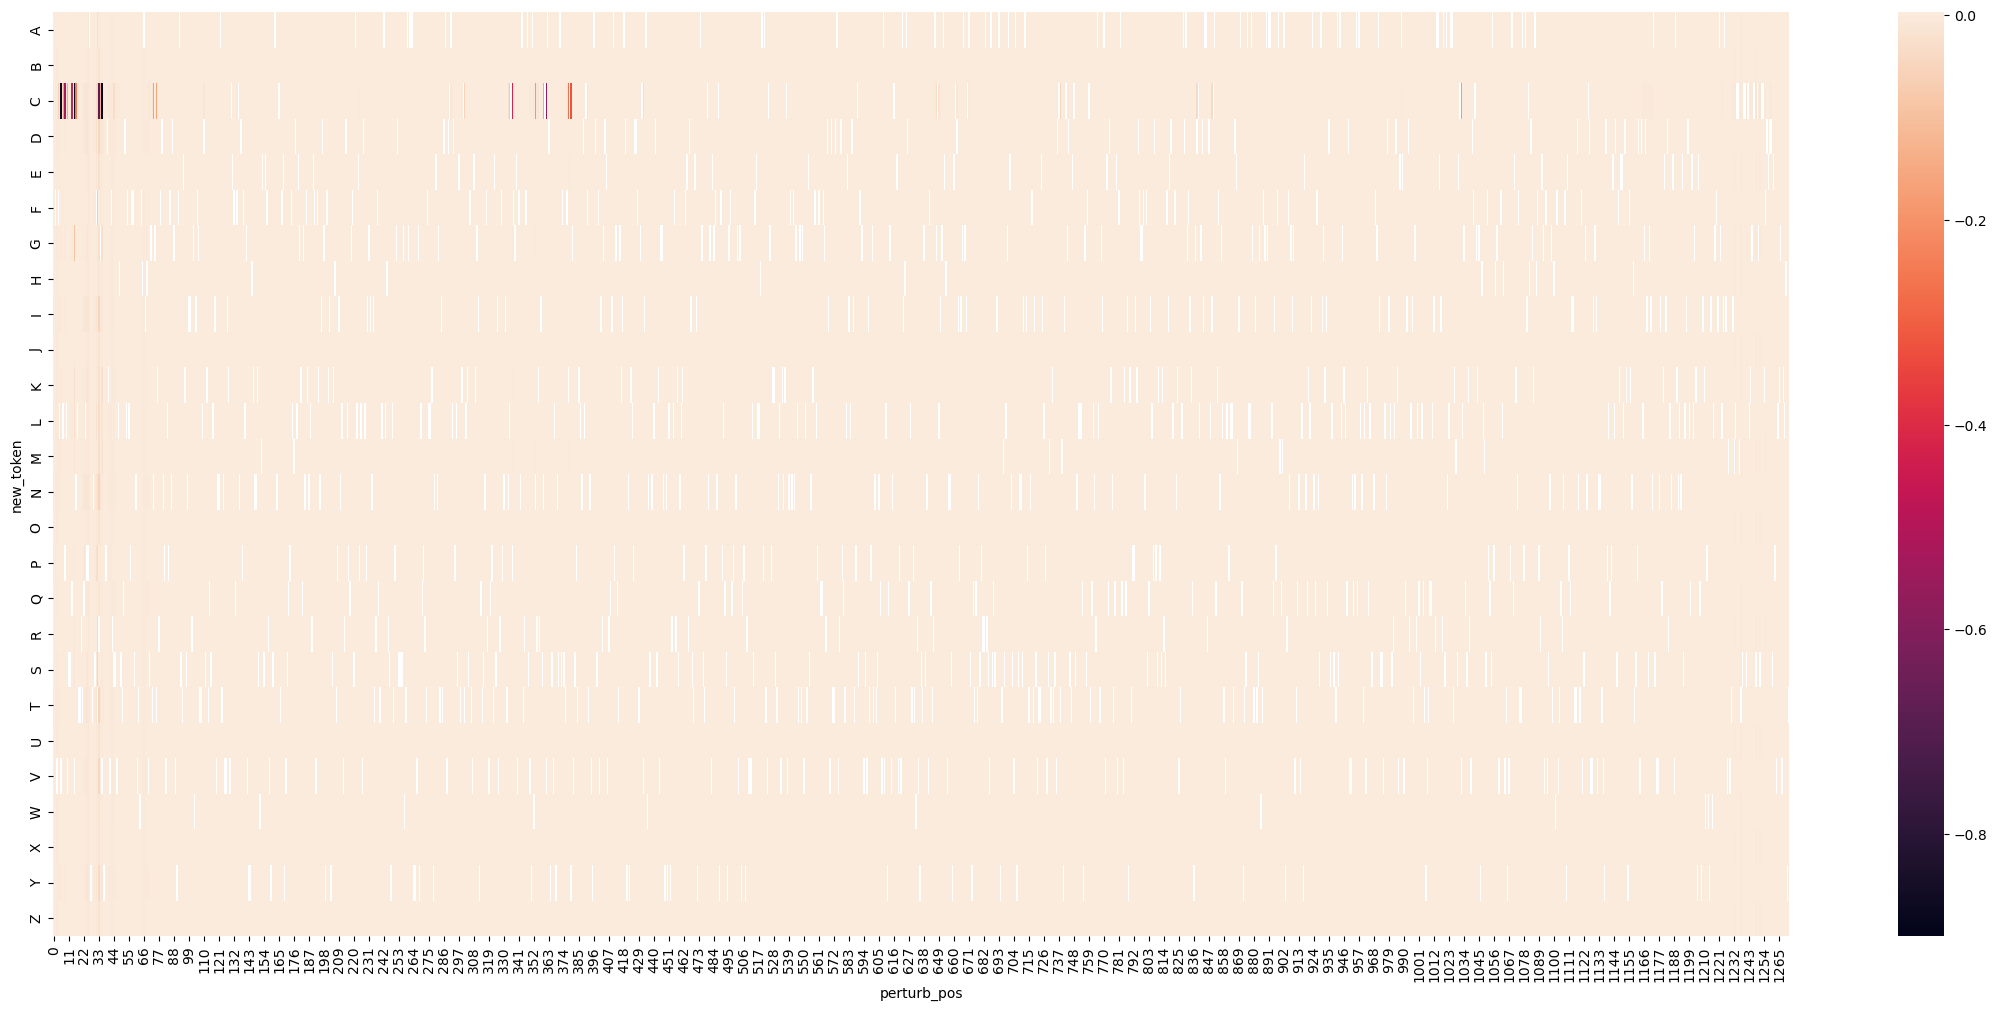

In [18]:
plt.figure(figsize=(28,12))
sns.heatmap(df)
plt.show()

In [19]:
df.mean(axis=0)

perturb_pos
0      -0.000052
1       0.000103
2      -0.000967
3      -0.002868
4      -0.000866
          ...   
1268   -0.000140
1269    0.000253
1270    0.000079
1271    0.000318
1272   -0.000096
Length: 1273, dtype: float64

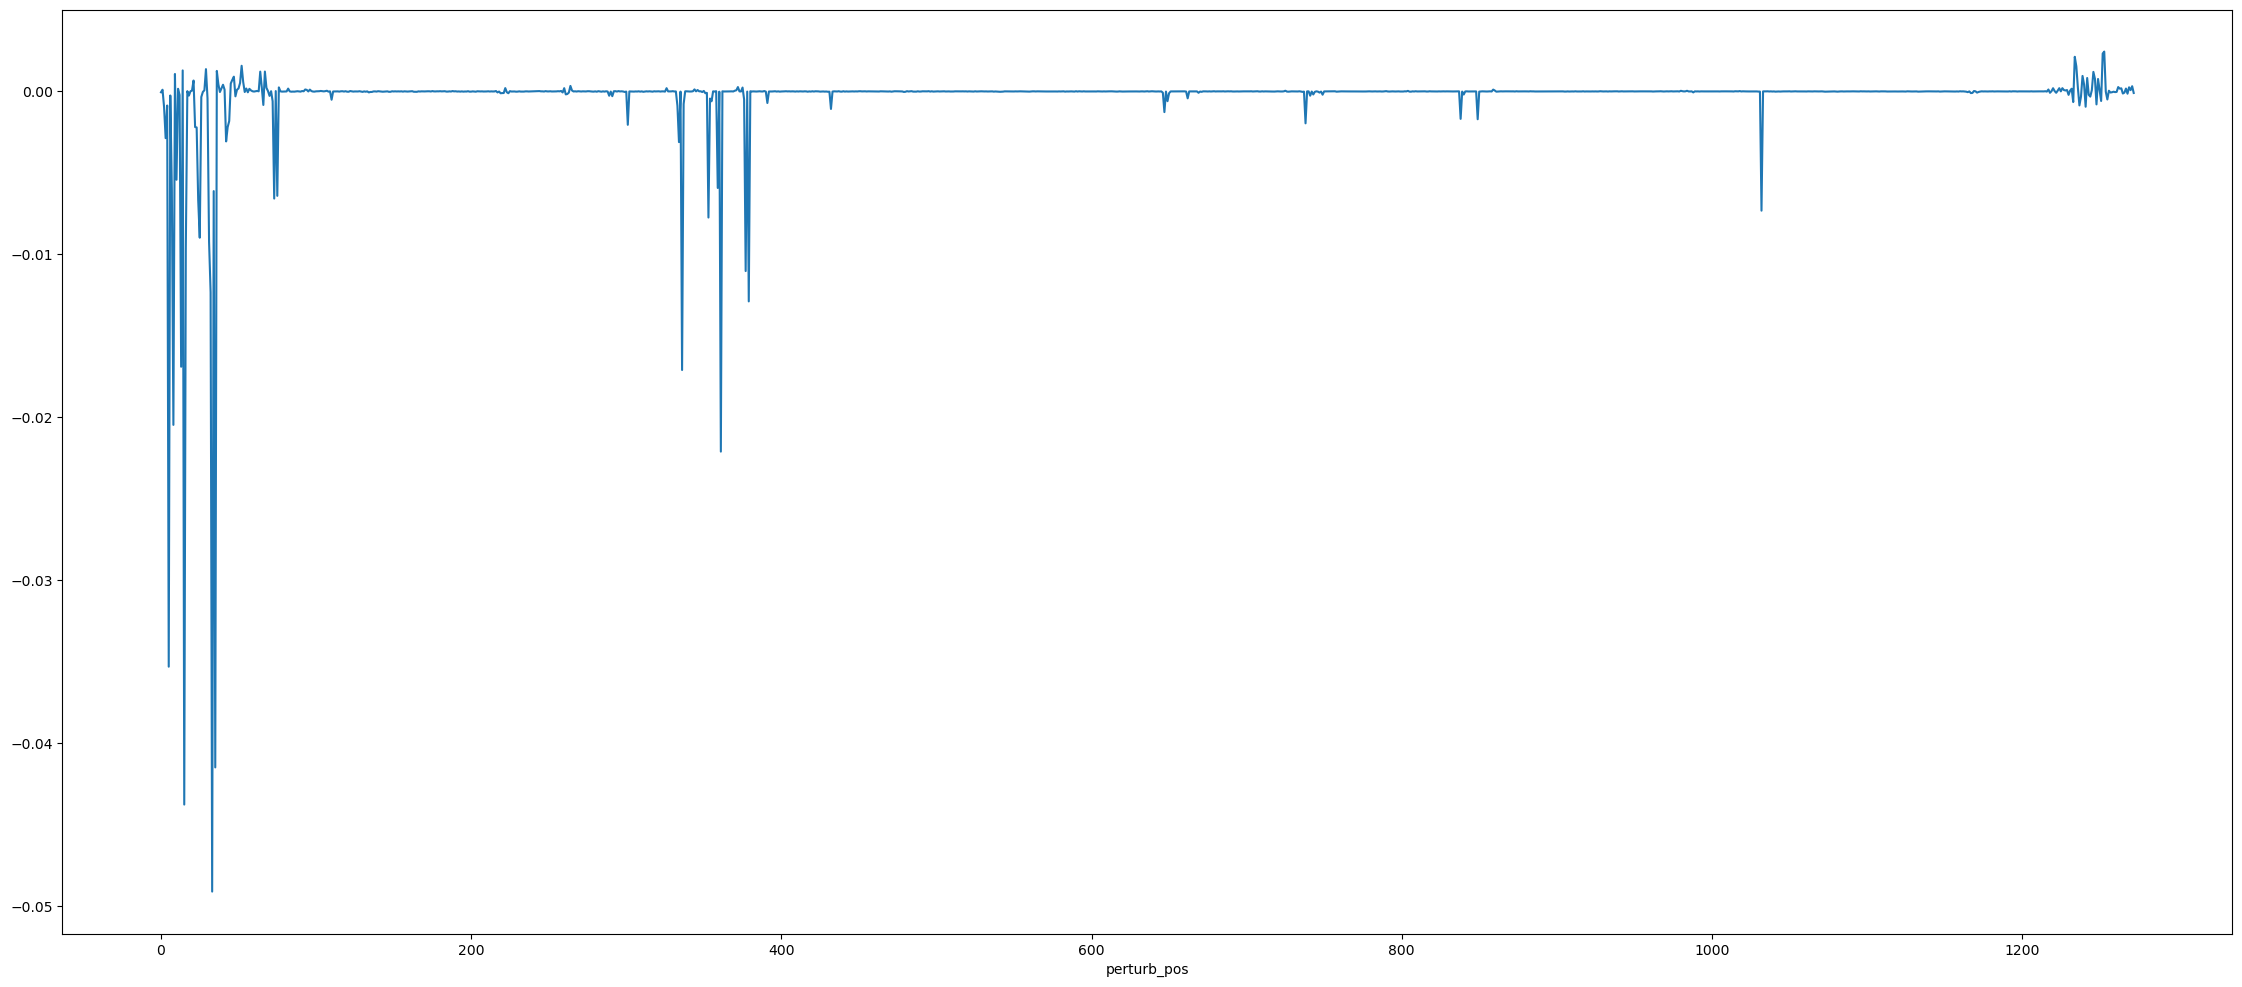

In [20]:
plt.figure(figsize=(28,12))
sns.lineplot(df.mean(axis=0))
plt.show()

In [21]:
df.mean(axis=0).idxmin()

33

In [22]:
mean_diff_dfs

[perturb_pos
 0      -0.000001
 1      -0.000002
 2      -0.000010
 3      -0.000033
 4      -0.000019
           ...   
 1245   -0.000005
 1246    0.000004
 1247    0.000002
 1248    0.000006
 1249   -0.000002
 Length: 1250, dtype: float64,
 perturb_pos
 0      -0.000055
 1       0.000116
 2      -0.001010
 3      -0.002872
 4      -0.000851
           ...   
 1268   -0.000133
 1269    0.000238
 1270    0.000074
 1271    0.000299
 1272   -0.000091
 Length: 1273, dtype: float64,
 perturb_pos
 0       1.202979e-07
 1      -1.232255e-05
 2      -5.368375e-05
 3      -1.747159e-03
 4      -8.674729e-04
             ...     
 1351    5.218517e-07
 1352   -1.604548e-06
 1353    5.451721e-09
 1354   -6.848948e-06
 1355    3.371452e-06
 Length: 1356, dtype: float64,
 perturb_pos
 0      -0.000018
 1       0.000040
 2      -0.000312
 3      -0.000839
 4      -0.000236
           ...   
 1268   -0.000034
 1269    0.000058
 1270    0.000017
 1271    0.000073
 1272   -0.000024
 Length: 1273, dtyp

In [23]:
mean_diff_df = pd.DataFrame(mean_diff_dfs)

In [24]:
mean_diff_df

perturb_pos          0             1         2         3         4     \
0           -1.286996e-06 -1.719580e-06 -0.000010 -0.000033 -0.000019   
1           -5.537050e-05  1.161207e-04 -0.001010 -0.002872 -0.000851   
2            1.202979e-07 -1.232255e-05 -0.000054 -0.001747 -0.000867   
3           -1.826358e-05  3.971711e-05 -0.000312 -0.000839 -0.000236   
4           -5.226536e-05  1.026054e-04 -0.000967 -0.002869 -0.000866   
...                   ...           ...       ...       ...       ...   
1579        -2.859400e-05  6.249598e-05 -0.000490 -0.001309 -0.000370   
1580         4.983027e-07  1.671349e-06 -0.000068 -0.002520 -0.001340   
1581        -5.540466e-09 -5.815405e-07 -0.000002 -0.000080 -0.000016   
1582        -1.402382e-05  2.835501e-05 -0.000229 -0.000615 -0.000173   
1583        -5.214994e-05  1.026872e-04 -0.000967 -0.002868 -0.000866   

perturb_pos      5         6             7         8         9     ...  \
0           -0.000006 -0.000023 -4.575802e-07 -0.000010 -0.000594  ...   
1           -0.035213  0.000605 -5.602066e-03 -0.020257  0.000877  ...   
2           -0.016739 -0.000364 -1.431017e-04 -0.001371 -0.000278  ...   
3           -0.026998  0.000636 -1.684335e-03 -0.008876  0.000421  ...   
4           -0.035292 -0.000252 -5.981943e-03 -0.020459  0.001069  ...   
...               ...       ...           ...       ...       ...  ...   
1579        -0.030583  0.001004 -2.541980e-03 -0.012312  0.000660  ...   
1580        -0.022574 -0.000676 -5.104607e-04 -0.000295  0.000264  ...   
1581        -0.000040 -0.000130 -1.606634e-05 -0.000011 -0.000013  ...   
1582        -0.024098  0.000464 -1.238317e-03 -0.006863  0.000218  ...   
1583        -0.035291 -0.000251 -5.980880e-03 -0.020458  0.001069  ...   

perturb_pos          1356          1357          1358      1359      1360  \
0                     NaN           NaN           NaN       NaN       NaN   
1                     NaN           NaN           NaN       NaN       NaN   
2                     NaN           NaN           NaN       NaN       NaN   
3                     NaN           NaN           NaN       NaN       NaN   
4                     NaN           NaN           NaN       NaN       NaN   
...                   ...           ...           ...       ...       ...   
1579                  NaN           NaN           NaN       NaN       NaN   
1580                  NaN           NaN           NaN       NaN       NaN   
1581         5.365953e-08 -2.139405e-07  6.968595e-07  0.000002  0.000005   
1582                  NaN           NaN           NaN       NaN       NaN   
1583                  NaN           NaN           NaN       NaN       NaN   

perturb_pos      1361      1362      1363      1364     1365  
0                 NaN       NaN       NaN       NaN      NaN  
1                 NaN       NaN       NaN       NaN      NaN  
2                 NaN       NaN       NaN       NaN      NaN  
3                 NaN       NaN       NaN       NaN      NaN  
4                 NaN       NaN       NaN       NaN      NaN  
...               ...       ...       ...       ...      ...  
1579              NaN       NaN       NaN       NaN      NaN  
1580              NaN       NaN       NaN       NaN      NaN  
1581         0.000005  0.000002  0.000014  0.000013  0.00001  
1582              NaN       NaN       NaN       NaN      NaN  
1583              NaN       NaN       NaN       NaN      NaN  

[1584 rows x 1366 columns]

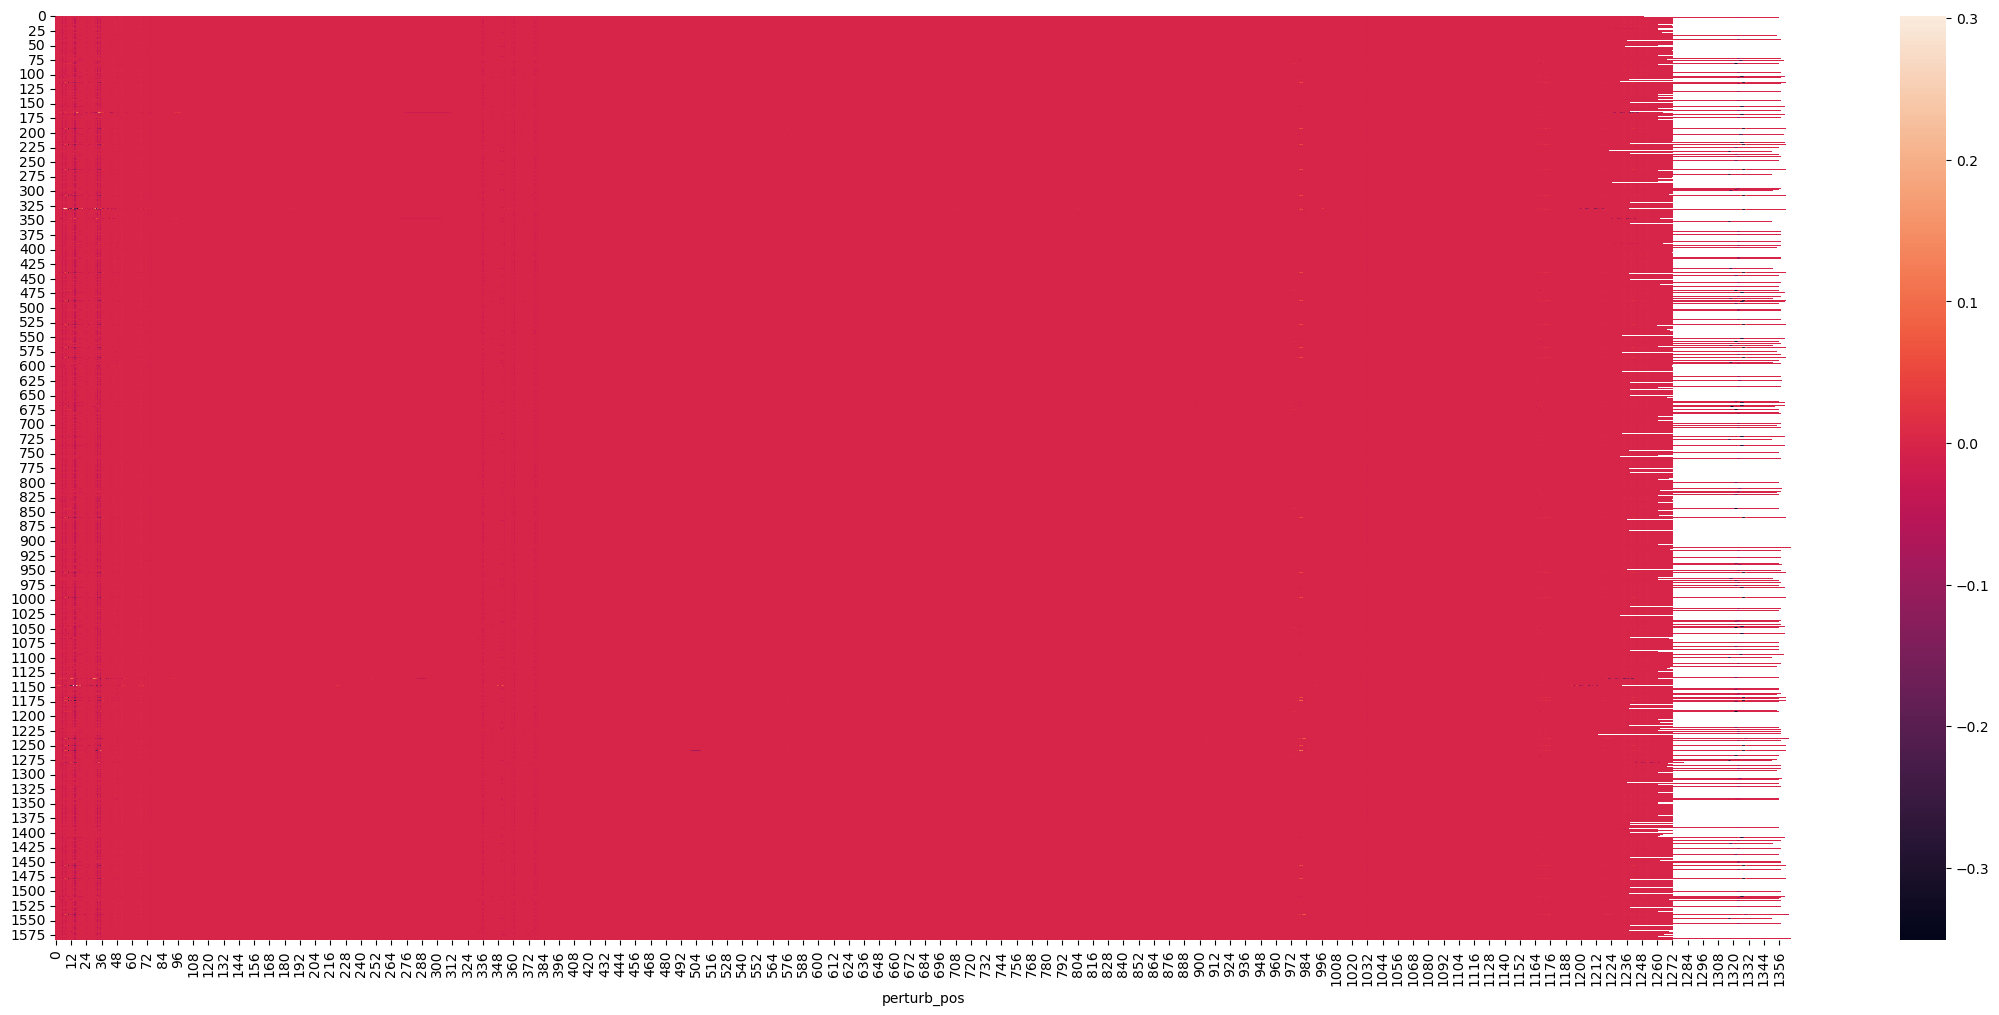

In [25]:
plt.figure(figsize=(28,12))
sns.heatmap(mean_diff_df)
plt.show()

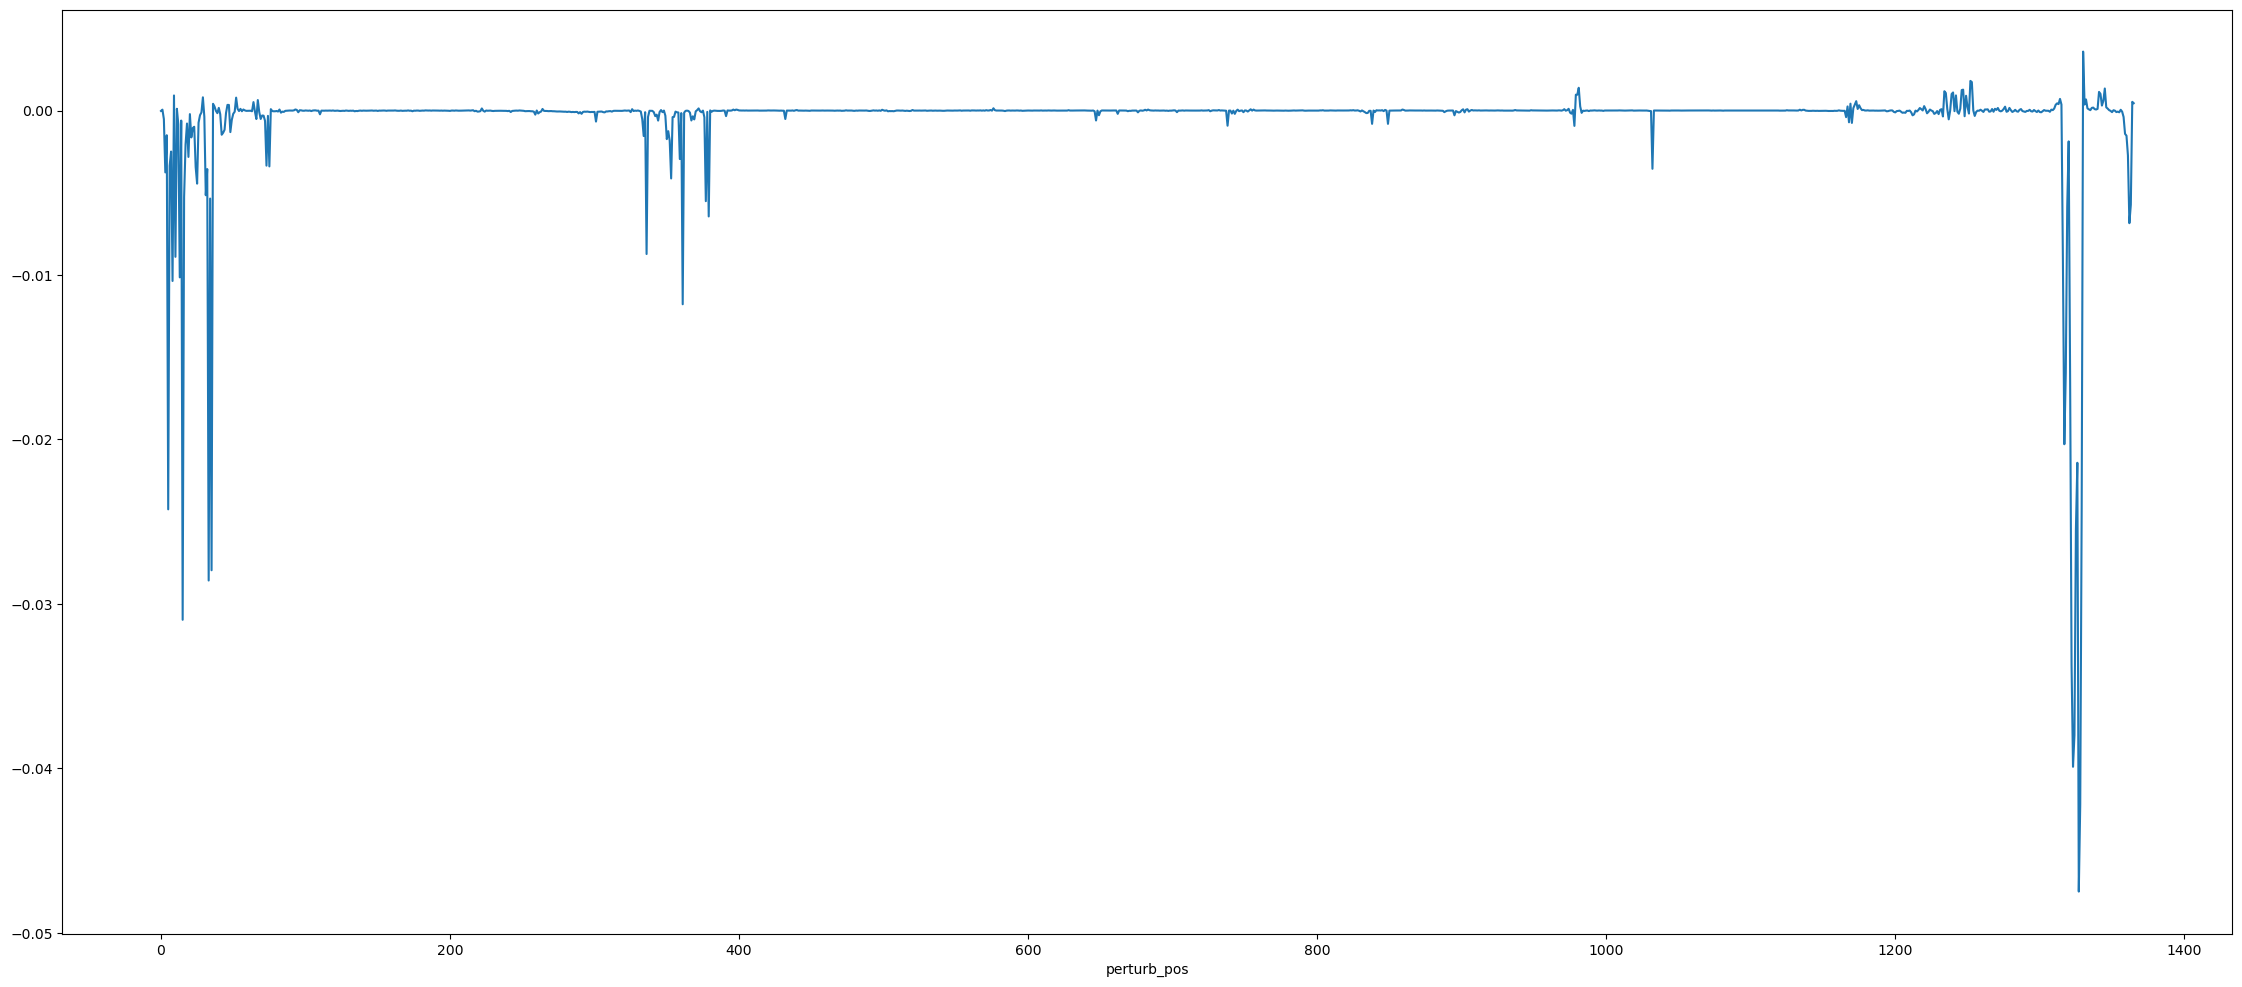

In [26]:
plt.figure(figsize=(28,12))
sns.lineplot(mean_diff_df.mean(axis=0))
plt.show()

In [27]:
mean_diff_df.mean(axis=0).idxmin()

1327

In [28]:
# retain only negative values i.e. probability of Human host decreases
mean_diff_df[mean_diff_df >= 0 ] = None
# drop all columns (positions) with all NaN i.e. this position is not in the top 10 for any sequence
# true_pred_attn_rank_df.dropna(axis=1, how="all", inplace=True)

# drop all columns (positions) with atleast 10% non-NaN values i.e. this position is not in the top 10 for 90% or more of the sequences
# argument 'thresh': Require that many non-NA values.
mean_diff_df.dropna(axis=1, how="all", thresh=0.9*mean_diff_df.shape[0], inplace=True)

In [29]:
mean_diff_df.shape

(1584, 68)

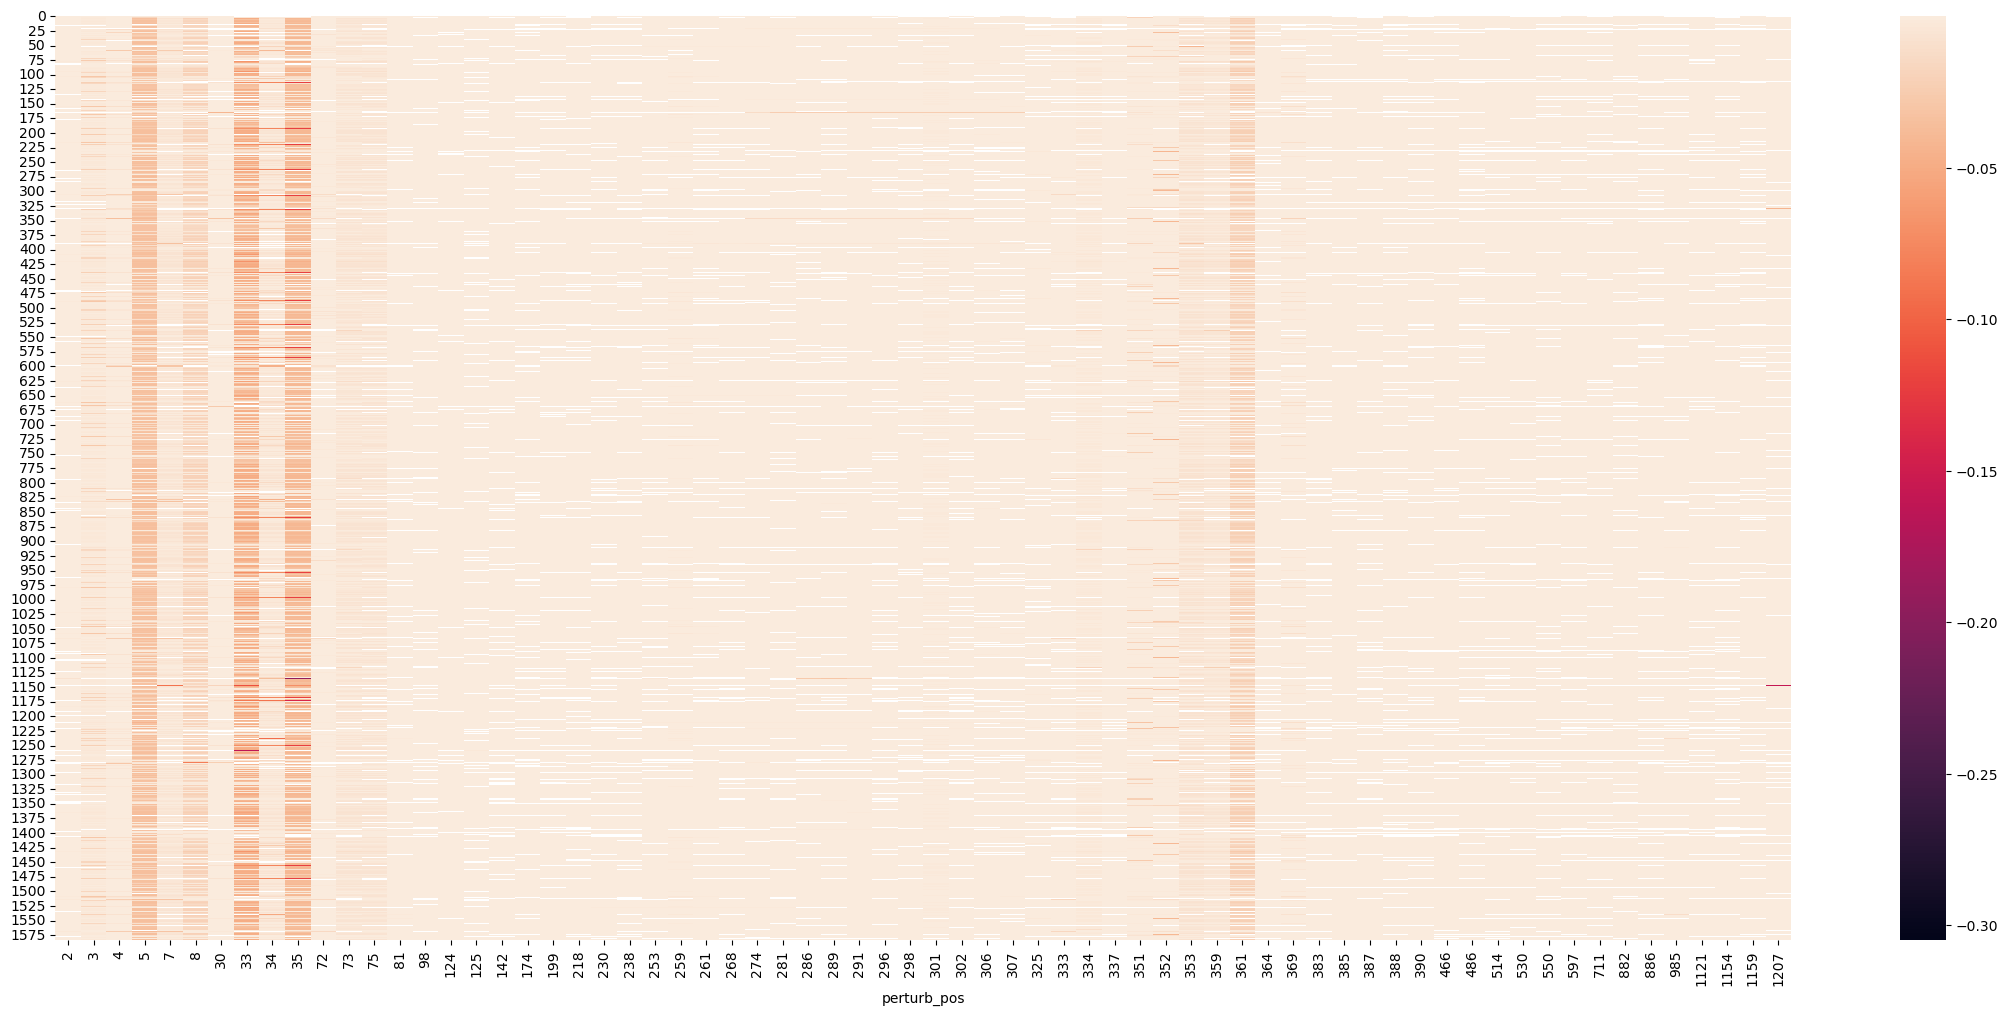

In [30]:
plt.figure(figsize=(28,12))
sns.heatmap(mean_diff_df)
plt.show()

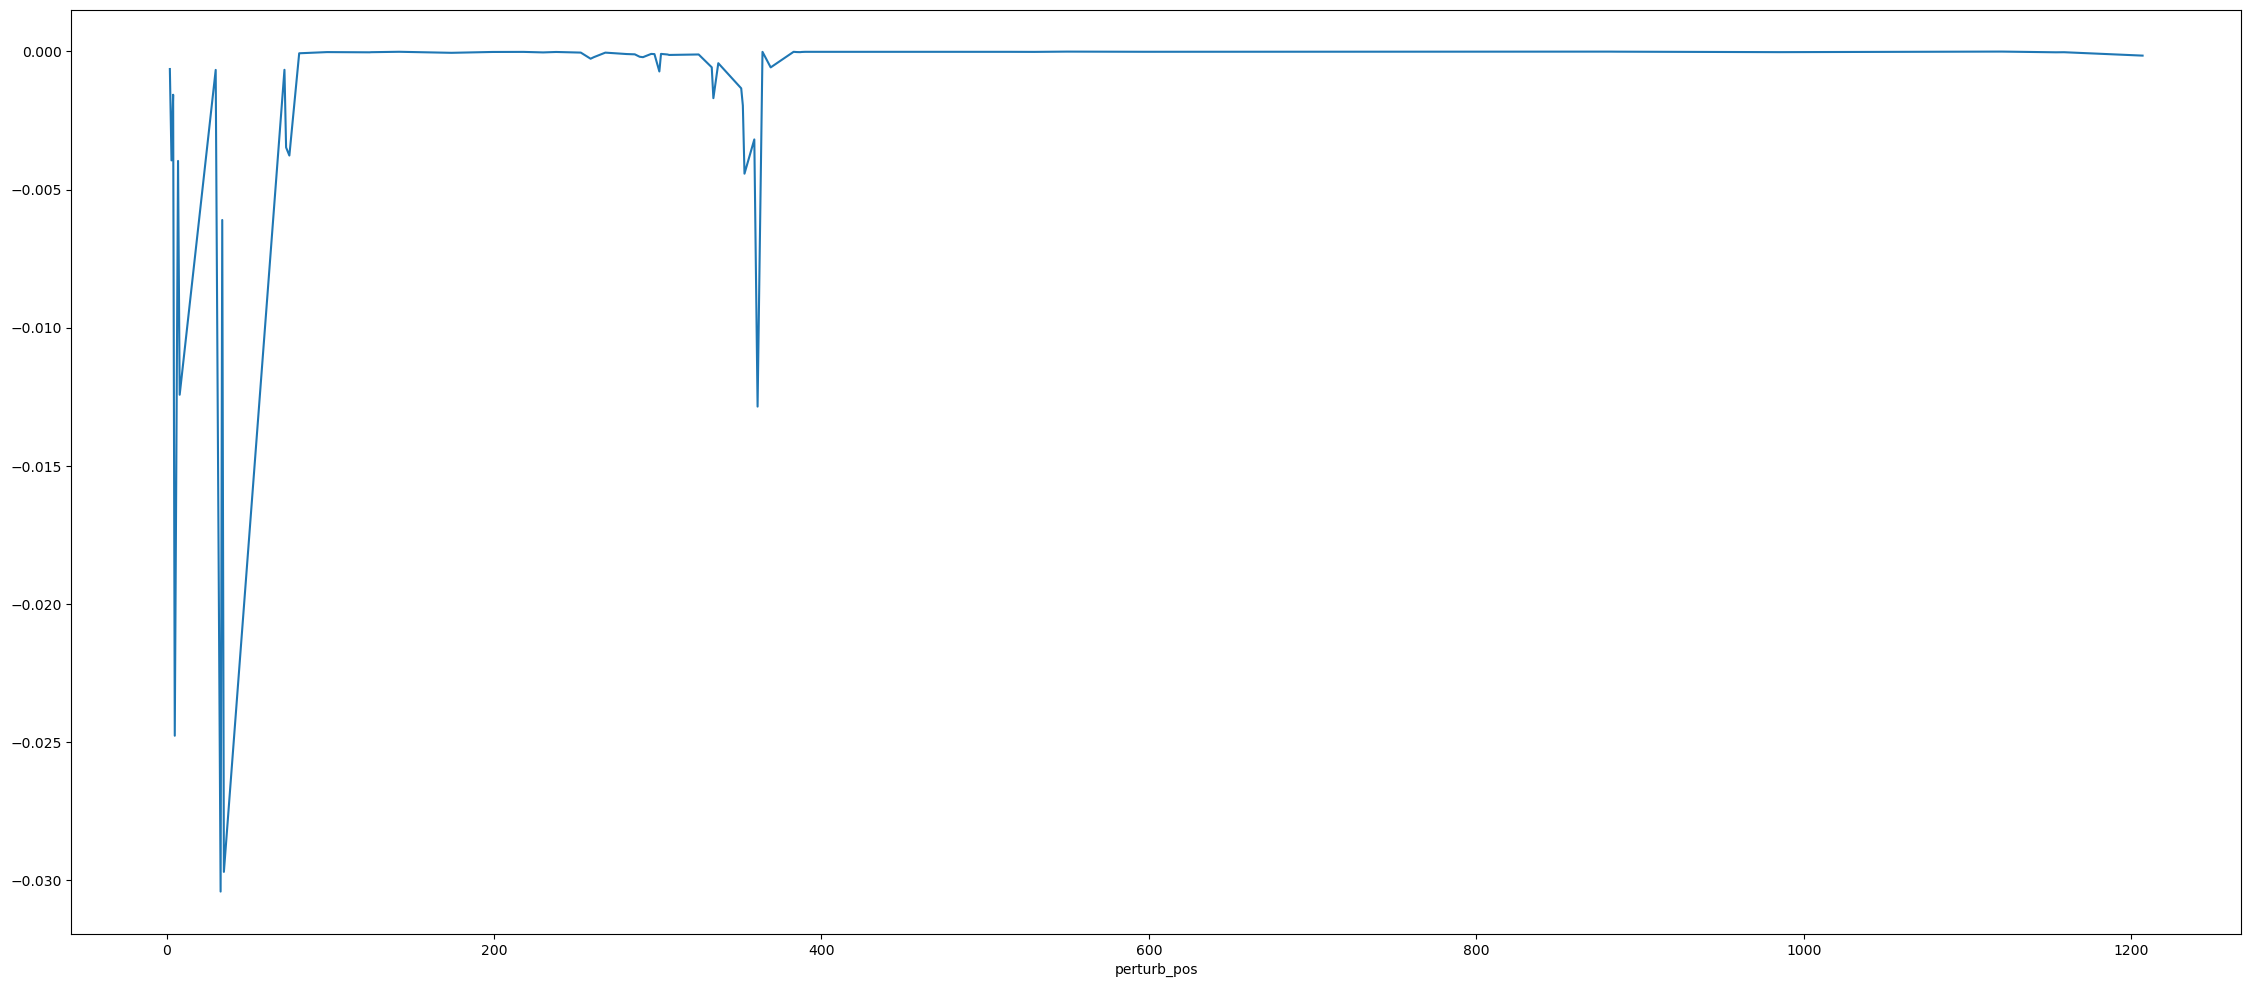

In [31]:
plt.figure(figsize=(28,12))
sns.lineplot(mean_diff_df.mean(axis=0))
plt.show()

In [32]:
mean_diff_df.mean(axis=0).nsmallest(10)

perturb_pos
33    -0.030429
35    -0.029715
5     -0.024784
361   -0.012863
8     -0.012434
34    -0.006104
353   -0.004426
7     -0.003965
3     -0.003946
75    -0.003770
dtype: float64

### A372T mutation in Wuhan Spike protein of SARS-CoV-2 infecting humans

In [33]:
w_sprot_input_filepath = "/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/sarscov2-S-WIV04ref.csv"
w_sprot_perturbed_output_filepath = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/sarscov2-S-WIV04/20230917/perturbed_dataset_prediction/cnn-l_4-lr1e-4/processed/cnn_sarscov2-S-WIV04ref.csv_WIV04.csv"

In [34]:
df = pd.read_csv(w_sprot_input_filepath)
wuhan_seq = df["seq"][0]
df

id                                                seq  \
0  WIV04  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   

                                         virus  seq_len  \
0  WIV04(MN996528.1) Wuhan variant index virus     1273   

                           virus_host binary_label  
0  Homo sapiens (Human) [TaxID: 9606]        Human

In [35]:
index_label_map, w_dataset_loader = get_token_dataset_loader(df, test_sequence_settings, label_settings)

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/../../prediction/datasets/protein_sequence_dataset.py:29: SettingWith

In [38]:
inputs, output_df = validate(cnn_model, w_dataset_loader, index_label_map)
perturbed_output_df = pd.read_csv(w_sprot_perturbed_output_filepath)

orig_seq_human_pred = output_df["Human"].values[0]
print(f"Prediction for human class for original sequence: {orig_seq_human_pred}")
perturbed_output_df = perturbed_output_df[["Human", "id", "orig_token", "perturb_pos", "new_token"]]
perturbed_output_df["pred_diff"] = perturbed_output_df["Human"] - orig_seq_human_pred
pivot_df = perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values="pred_diff")

Prediction for human class for original sequence: 0.9886878132820129


In [39]:
print(f"Wuhan Sequence = {wuhan_seq}")
print(f"wuhan_seq pos 372 = wuhan_seq[371]: {wuhan_seq[371]}")
print(f"wuhan_seq pos 372 = wuhan_seq[372]: {wuhan_seq[372]}")
pivot_df[[370, 371, 372]]

Wuhan Sequence = MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSR

perturb_pos           370           371           372
new_token                                            
A            9.701267e-04           NaN  2.015887e-03
B            1.686718e-06 -7.863282e-06 -5.013282e-06
C            1.438672e-05  7.286718e-06  2.133672e-05
D            3.036718e-06  1.886718e-06 -6.328201e-08
E            6.867180e-07 -9.313282e-06  8.463672e-05
F            1.178672e-05  1.286718e-06  2.076027e-03
G           -4.513282e-06 -1.141328e-05 -8.813282e-06
H            4.686718e-06  1.280887e-03 -3.113282e-06
I            7.156718e-06  4.486718e-06 -6.973282e-06
J            1.686718e-06 -7.813282e-06 -5.113282e-06
K            2.486718e-06 -3.573282e-06 -3.113282e-06
L           -4.773282e-06 -1.055328e-05 -8.913282e-06
M            4.946718e-06 -4.413282e-06 -3.713282e-06
N            1.738672e-05 -1.513282e-06  1.305672e-05
O            1.426718e-06 -7.863282e-06 -4.173282e-06
P            5.986718e-06 -2.683282e-06  4.994867e-04
Q            5.126718e-06  5.264267e-04 -6.013282e-06
R            3.286718e-06 -8.213282e-06  1.304747e-03
S                     NaN  2.298672e-05           NaN
T            1.178672e-05  1.426718e-06  1.786718e-06
U            1.426718e-06 -8.113282e-06 -4.653282e-06
V            5.486718e-06  8.367180e-07 -2.313282e-06
W            1.686718e-06 -7.313282e-06 -6.853282e-06
X            3.036718e-06 -6.113282e-06  7.078867e-04
Y           -5.543282e-06 -2.713282e-06 -6.853282e-06
Z            1.426718e-06 -7.863282e-06 -4.513282e-06

In [40]:
perturbed_output_df

Human     id orig_token  perturb_pos new_token     pred_diff
0      0.988687  WIV04          K          299         X -1.113282e-06
1      0.988686  WIV04          E          131         B -2.213282e-06
2      0.988692  WIV04          T         1065         F  3.756718e-06
3      0.988689  WIV04          Q         1009         B  8.367180e-07
4      0.988679  WIV04          F          305         S -8.913282e-06
...         ...    ...        ...          ...       ...           ...
31821  0.988680  WIV04          N          459         G -7.713282e-06
31822  0.988694  WIV04          I          586         T  5.986718e-06
31823  0.988683  WIV04          K         1027         N -4.653282e-06
31824  0.988748  WIV04          F           58         B  5.968672e-05
31825  0.988664  WIV04          N          195         A -2.431328e-05

[31826 rows x 6 columns]

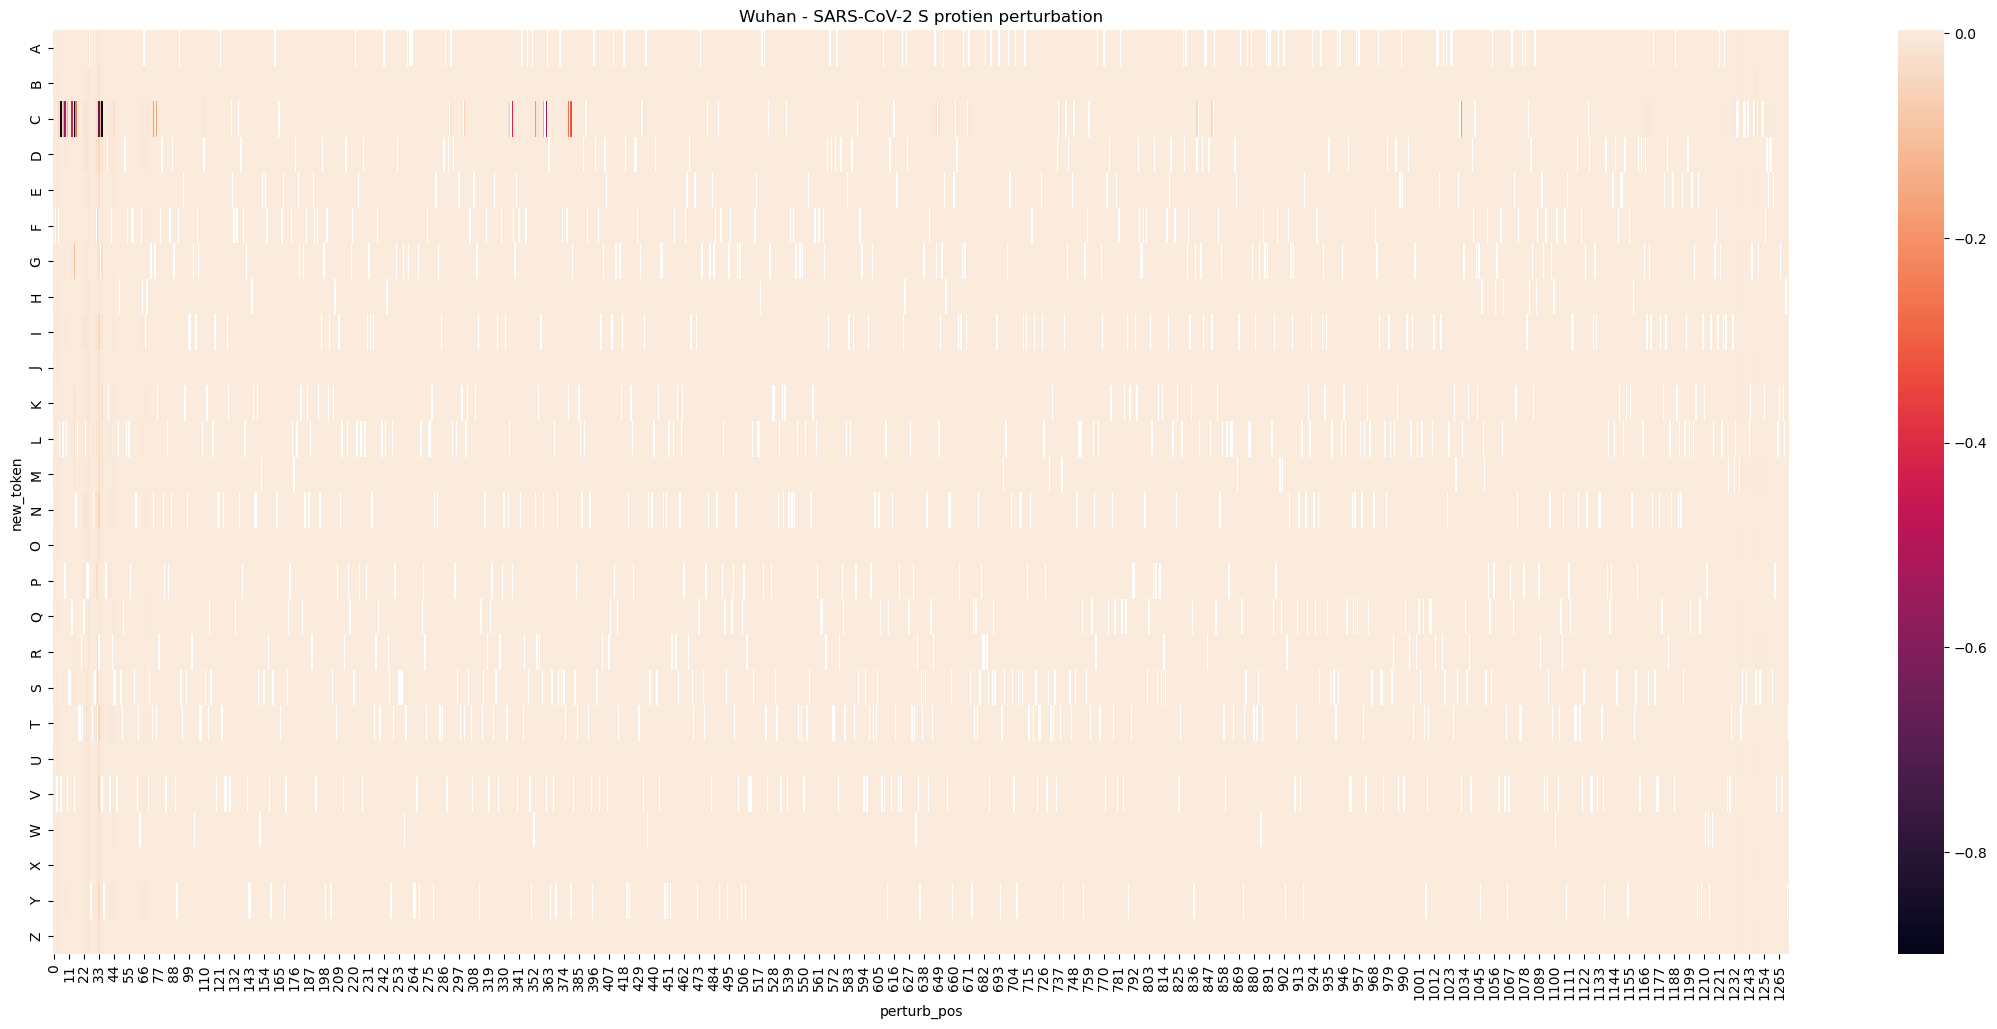

In [41]:
plt.figure(figsize=(28,12))
ax = sns.heatmap(pivot_df)
ax.set_title("Wuhan - SARS-CoV-2 S protien perturbation")
plt.show()

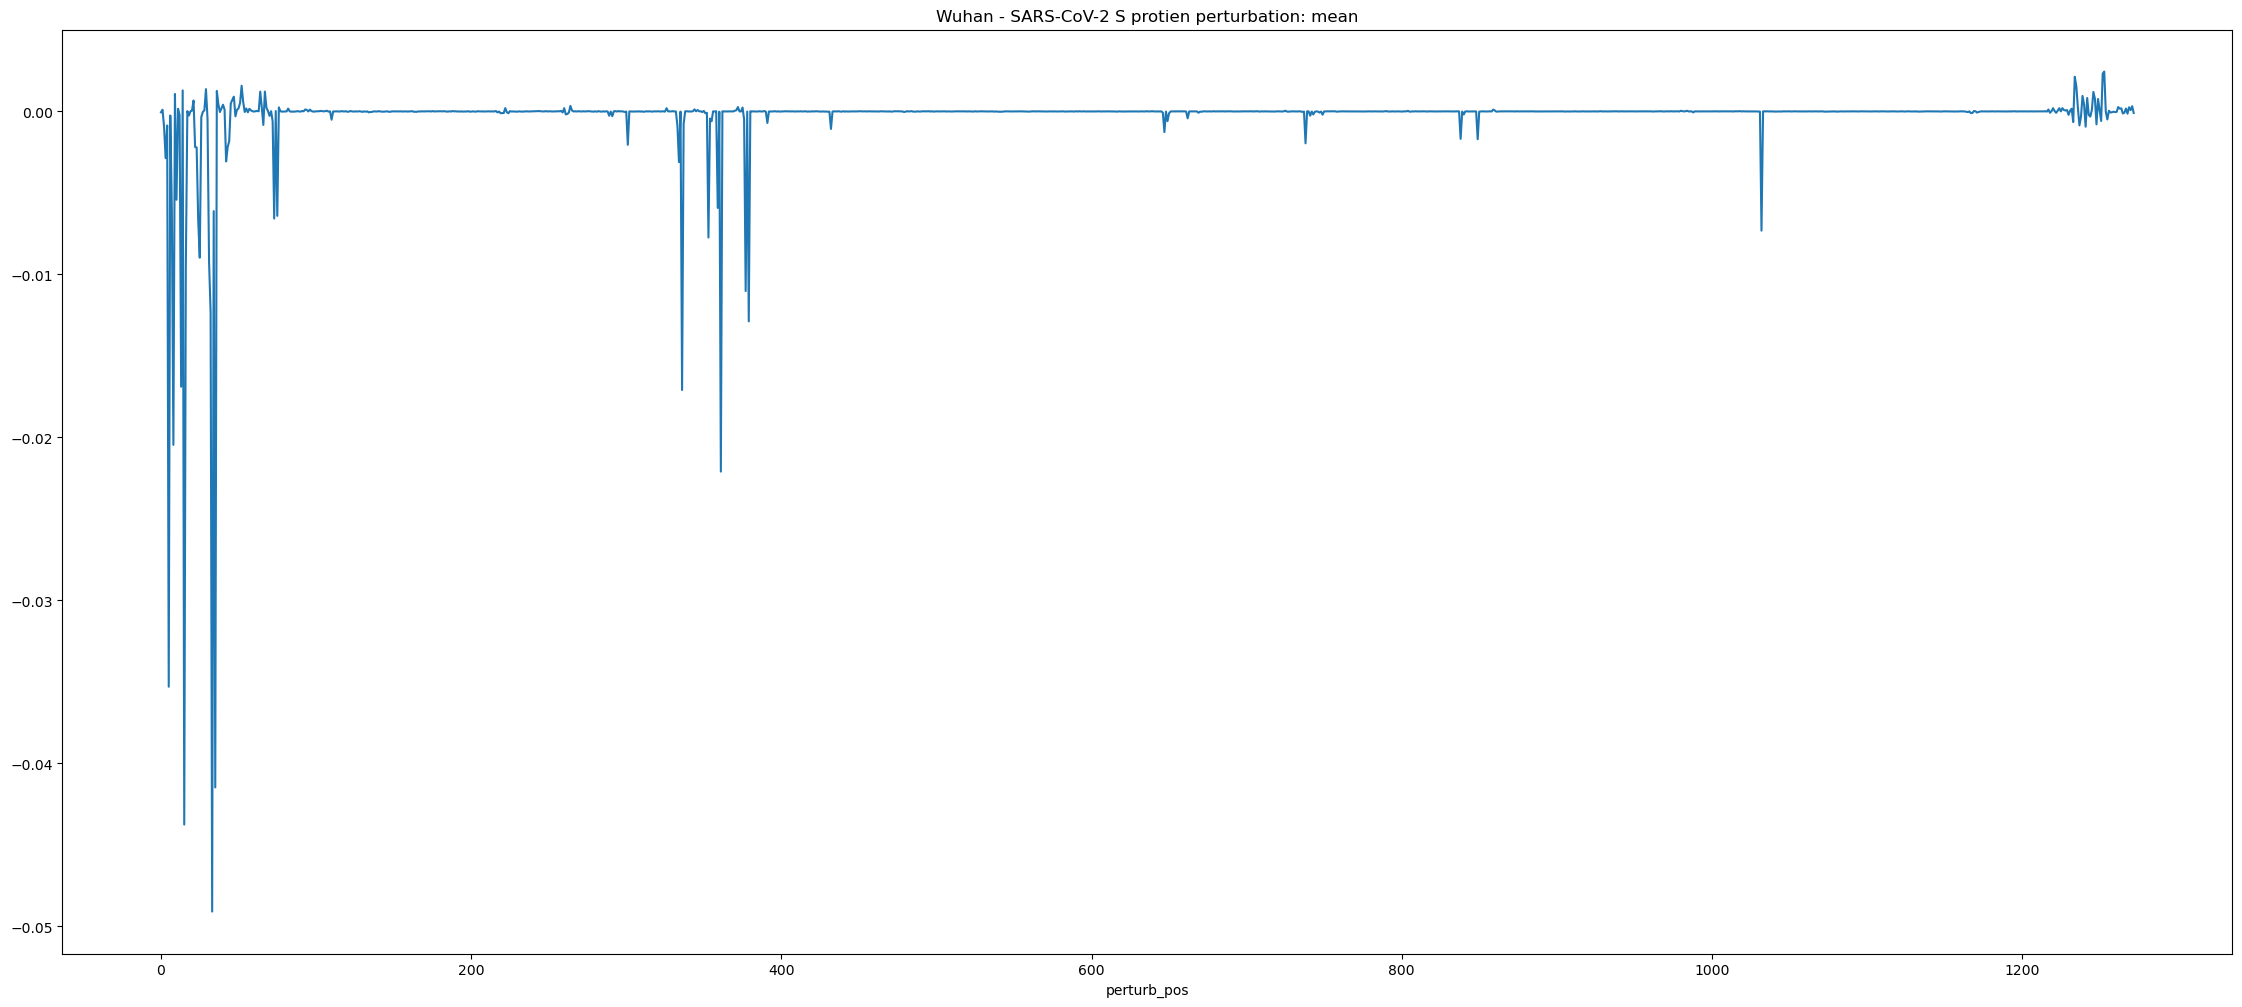

In [43]:
plt.figure(figsize=(28,12))
ax = sns.lineplot(pivot_df.mean(axis=0))
ax.set_title("Wuhan - SARS-CoV-2 S protien perturbation: mean")
plt.show()

In [48]:
pivot_df.mean(axis=0).nsmallest(10)

perturb_pos
33    -0.049085
15    -0.043749
35    -0.041469
5     -0.035291
361   -0.022096
8     -0.020457
336   -0.017090
13    -0.016890
379   -0.012882
32    -0.012333
dtype: float64